# Phase 2: Dataset Processing and Preparation

## 2.1 Environment Setup and Validation

In [ ]:
# Import required libraries
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import (
    T5ForConditionalGeneration, T5Tokenizer,
    RobertaForSequenceClassification, RobertaTokenizer, RobertaTokenizerFast,
    AutoModelForSequenceClassification, AutoTokenizer
)

import logging
from tqdm.notebook import tqdm
import gc
from collections import Counter

# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# Define paths
BASE_DIR = '/content/drive/MyDrive/DL4H-Project'
DATA_DIR = os.path.join(BASE_DIR, 'data')
MODELS_DIR = os.path.join(BASE_DIR, 'models')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')

# Dataset paths
MEDNLI_DIR = os.path.join(DATA_DIR, 'mednli')
RADQA_DIR = os.path.join(DATA_DIR, 'radqa')
CLIP_DIR = os.path.join(DATA_DIR, 'clip')

# Model paths
PRETRAINED_DIR = os.path.join(MODELS_DIR, 'pretrained')
FINETUNED_DIR = os.path.join(MODELS_DIR, 'finetuned')

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(BASE_DIR, 'phase2.log')),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("phase2")
logger.info("Starting Phase 2: Dataset Processing")

# Define model specifications
MODEL_SPECS = {
    't5-base': {
        'name': 't5-base',
        'source': 't5-base',
        'parameters': 220_000_000,
        'type': 'encoder-decoder',
        'domain': 'general',
        'tokenizer_class': T5Tokenizer
    },
    't5-large': {
        'name': 't5-large',
        'source': 't5-large',
        'parameters': 770_000_000,
        'type': 'encoder-decoder',
        'domain': 'general',
        'tokenizer_class': T5Tokenizer
    },
    'roberta-large': {
        'name': 'roberta-large',
        'source': 'roberta-large',
        'parameters': 345_000_000,
        'type': 'encoder-only',
        'domain': 'general',
        'tokenizer_class': RobertaTokenizer
    },
    'bio-clinical-bert': {
        'name': 'bio-clinical-bert',
        'source': 'emilyalsentzer/Bio_ClinicalBERT',
        'parameters': 345_000_000,
        'type': 'encoder-only',
        'domain': 'clinical',
        'tokenizer_class': AutoTokenizer
    },
    'gatortron': {
        'name': 'gatortron',
        'source': 'UFNLP/gatortron-base',
        'parameters': 345_000_000,
        'type': 'encoder-only',
        'domain': 'clinical',
        'tokenizer_class': AutoTokenizer
    }
}

# Task specifications
TASK_SPECS = {
    'mednli': {
        'name': 'mednli',
        'type': 'classification',
        'num_labels': 3,
        'labels': ['entailment', 'neutral', 'contradiction'],
        'metrics': ['accuracy'],
        'encoder_input_format': '{premise} [SEP] {hypothesis}',
        'encoder_decoder_input_format': 'mnli premise: {premise} hypothesis: {hypothesis}',
        'max_length': 256
    },
    'radqa': {
        'name': 'radqa',
        'type': 'question-answering',
        'metrics': ['f1', 'exact_match'],
        'encoder_input_format': '{question} [SEP] {context}',
        'encoder_decoder_input_format': 'question: {question} context: {context}',
        'max_length': 512
    },
    'clip': {
        'name': 'clip',
        'type': 'multi-label-classification',
        'num_labels': 7,
        'labels': [
            'appointment-related',
            'medication-related',
            'lab-related',
            'patient-instructions',
            'procedure-related',
            'imaging-related',
            'other'
        ],
        'metrics': ['micro_f1', 'macro_f1'],
        'encoder_input_format': '{sentence}',
        'encoder_decoder_input_format': 'clip: {sentence}',
        'max_length': 256
    }
}

# Helper function to check if directory exists
def check_directory(path):
    exists = os.path.exists(path)
    if exists:
        logger.info(f"✓ Directory exists: {path}")
    else:
        logger.warning(f"✗ Directory missing: {path}")
    return exists

# Helper function to check if file exists
def check_file(path):
    exists = os.path.exists(path)
    if exists:
        logger.info(f"✓ File exists: {path}")
    else:
        logger.warning(f"✗ File missing: {path}")
    return exists

# Check hardware
def check_hardware():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    if device.type == "cuda":
        logger.info(f"CUDA device: {torch.cuda.get_device_name(0)}")
        logger.info(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

    return device

# Validate required directories
logger.info("Checking required directories...")
directories_ok = (
    check_directory(BASE_DIR) and
    check_directory(DATA_DIR) and
    check_directory(MODELS_DIR) and
    check_directory(RESULTS_DIR) and
    check_directory(MEDNLI_DIR) and
    check_directory(RADQA_DIR) and
    check_directory(CLIP_DIR) and
    check_directory(PRETRAINED_DIR) and
    check_directory(FINETUNED_DIR)
)

# Check MedNLI dataset files
logger.info("Checking MedNLI files...")
mednli_files_ok = (
    check_file(os.path.join(MEDNLI_DIR, "mli_train_v1.jsonl")) and
    check_file(os.path.join(MEDNLI_DIR, "mli_dev_v1.jsonl")) and
    check_file(os.path.join(MEDNLI_DIR, "mli_test_v1.jsonl"))
)

# Check RadQA dataset files
logger.info("Checking RadQA files...")
radqa_files_ok = (
    check_file(os.path.join(RADQA_DIR, "train.json")) and
    check_file(os.path.join(RADQA_DIR, "dev.json")) and
    check_file(os.path.join(RADQA_DIR, "test.json"))
)

# Check CLIP dataset files
logger.info("Checking CLIP files...")
clip_files_ok = (
    check_file(os.path.join(CLIP_DIR, "sentence_level.csv")) and
    check_file(os.path.join(CLIP_DIR, "train_ids.csv")) and
    check_file(os.path.join(CLIP_DIR, "val_ids.csv")) and
    check_file(os.path.join(CLIP_DIR, "test_ids.csv"))
)

# Check if tokenizers can be loaded
logger.info("Checking if tokenizers can be loaded...")
tokenizers_ok = True
try:
    t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
    roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
    logger.info("✓ Base tokenizers loaded successfully")
except Exception as e:
    logger.error(f"✗ Error loading tokenizers: {e}")
    tokenizers_ok = False

# Validate CUDA availability
device = check_hardware()

# Overall validation result
environment_ok = (
    directories_ok and
    mednli_files_ok and
    radqa_files_ok and
    clip_files_ok and
    tokenizers_ok
)

# Print summary
print("\nEnvironment Validation Summary:")
print("--------------------------------")
print(f"Directories: {'✓' if directories_ok else '✗'}")
print(f"MedNLI files: {'✓' if mednli_files_ok else '✗'}")
print(f"RadQA files: {'✓' if radqa_files_ok else '✗'}")
print(f"CLIP files: {'✓' if clip_files_ok else '✗'}")
print(f"Tokenizers: {'✓' if tokenizers_ok else '✗'}")
print(f"CUDA available: {'✓' if device.type == 'cuda' else '✗'}")
print("\nOverall: " + ("✓ Environment OK" if environment_ok else "✗ Environment needs attention"))

# Sample dataset validation to ensure files are readable
try:
    # Sample MedNLI
    with open(os.path.join(MEDNLI_DIR, "mli_train_v1.jsonl"), 'r') as f:
        sample_mednli = json.loads(f.readline())

    # Sample RadQA
    with open(os.path.join(RADQA_DIR, "train.json"), 'r') as f:
        sample_radqa = json.load(f)

    # Sample CLIP
    sample_clip = pd.read_csv(os.path.join(CLIP_DIR, "sentence_level.csv"), nrows=5)

    logger.info("✓ Sample data loaded successfully")
    print("\nSample Data Validation: ✓")
except Exception as e:
    logger.error(f"✗ Error loading sample data: {e}")
    print("\nSample Data Validation: ✗")

# Log sample information
if environment_ok:
    logger.info("Environment validated successfully. Ready for dataset processing.")

    # Log MedNLI sample
    logger.info(f"MedNLI sample - premise: '{sample_mednli['sentence1'][:50]}...'")
    logger.info(f"MedNLI sample - hypothesis: '{sample_mednli['sentence2'][:50]}...'")
    logger.info(f"MedNLI sample - label: {sample_mednli['gold_label']}")

    # Log RadQA sample
    sample_paragraph = sample_radqa['data'][0]['paragraphs'][0]
    logger.info(f"RadQA sample - context: '{sample_paragraph['context'][:50]}...'")
    logger.info(f"RadQA sample - question: '{sample_paragraph['qas'][0]['question']}'")

    # Log CLIP sample
    logger.info(f"CLIP sample - sentence: '{sample_clip.iloc[0]['sentence'][:50]}...'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Environment Validation Summary:
--------------------------------
Directories: ✓
MedNLI files: ✓
RadQA files: ✓
CLIP files: ✓
Tokenizers: ✓
CUDA available: ✓

Overall: ✓ Environment OK

Sample Data Validation: ✓


## 2.2 MedNLI Dataset Processing

In [ ]:
# 2.2 MedNLI Dataset Processing
logger.info("Starting MedNLI dataset processing")

# Define constant file paths
MEDNLI_TRAIN_FILE = os.path.join(MEDNLI_DIR, "mli_train_v1.jsonl")
MEDNLI_DEV_FILE = os.path.join(MEDNLI_DIR, "mli_dev_v1.jsonl")
MEDNLI_TEST_FILE = os.path.join(MEDNLI_DIR, "mli_test_v1.jsonl")

# Define percentages for subsets
PERCENTAGES = {'full': 1.0, '25pct': 0.25, '10pct': 0.1, '5pct': 0.05, '1pct': 0.01}

# Dataset class for MedNLI
class MedNLIDataset(Dataset):
    """Base MedNLI dataset class."""

    def __init__(self, jsonl_file, tokenizer, max_length=256):
        """
        Initialize MedNLI dataset.
        Args:
            jsonl_file: Path to JSONL file
            tokenizer: Tokenizer for encoding text
            max_length: Maximum sequence length
        """
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.examples = []

        # Load data from JSONL file
        with open(jsonl_file, 'r') as f:
            for line in f:
                example = json.loads(line)
                self.examples.append(example)

        # Map label to id
        self.label_map = {"entailment": 0, "neutral": 1, "contradiction": 2}

        logger.info(f"Loaded {len(self.examples)} examples from {jsonl_file}")

    def __len__(self):
        return len(self.examples)

    def get_label_distribution(self):
        """Return label distribution in dataset."""
        labels = [example['gold_label'] for example in self.examples]
        return Counter(labels)

class MedNLIEncoderOnlyDataset(MedNLIDataset):
    """MedNLI dataset for encoder-only models (RoBERTa, etc.)"""

    def __init__(self, jsonl_file, tokenizer, max_length=256):
        super().__init__(jsonl_file, tokenizer, max_length)

    def __getitem__(self, idx):
        example = self.examples[idx]
        premise = example['sentence1']
        hypothesis = example['sentence2']
        label = self.label_map[example['gold_label']]

        # Format for encoder-only models: "{premise} [SEP] {hypothesis}"
        # The tokenizer will handle adding the special tokens
        encoding = self.tokenizer(
            premise,
            hypothesis,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Convert to pytorch tensors
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

class MedNLIEncoderDecoderDataset(MedNLIDataset):
    """MedNLI dataset for encoder-decoder models (T5, etc.)"""

    def __init__(self, jsonl_file, tokenizer, max_length=256):
        super().__init__(jsonl_file, tokenizer, max_length)
        # Map labels to text for T5
        self.id_to_label = {0: "entailment", 1: "neutral", 2: "contradiction"}

    def __getitem__(self, idx):
        example = self.examples[idx]
        premise = example['sentence1']
        hypothesis = example['sentence2']
        label = self.label_map[example['gold_label']]

        # Format for T5: "mnli premise: {premise} hypothesis: {hypothesis}"
        input_text = f"mnli premise: {premise} hypothesis: {hypothesis}"
        target_text = self.id_to_label[label]

        # Encode input
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Encode target
        target_encoding = self.tokenizer(
            target_text,
            max_length=8,  # Target is just a single word
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = input_encoding['input_ids'].squeeze()
        attention_mask = input_encoding['attention_mask'].squeeze()
        labels = target_encoding['input_ids'].squeeze()

        # Replace padding tokens in labels with -100 (ignored in loss)
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'label_id': torch.tensor(label, dtype=torch.long)
        }

def analyze_mednli_dataset():
    """Analyze MedNLI dataset and print statistics."""
    logger.info("Analyzing MedNLI dataset")

    # Load training data
    train_examples = []
    with open(MEDNLI_TRAIN_FILE, 'r') as f:
        for line in f:
            train_examples.append(json.loads(line))

    # Load dev data
    dev_examples = []
    with open(MEDNLI_DEV_FILE, 'r') as f:
        for line in f:
            dev_examples.append(json.loads(line))

    # Load test data
    test_examples = []
    with open(MEDNLI_TEST_FILE, 'r') as f:
        for line in f:
            test_examples.append(json.loads(line))

    # Count labels in each split
    train_labels = Counter([ex['gold_label'] for ex in train_examples])
    dev_labels = Counter([ex['gold_label'] for ex in dev_examples])
    test_labels = Counter([ex['gold_label'] for ex in test_examples])

    # Calculate sentence lengths
    train_premise_lengths = [len(ex['sentence1'].split()) for ex in train_examples]
    train_hypothesis_lengths = [len(ex['sentence2'].split()) for ex in train_examples]

    # Print statistics
    print("\nMedNLI Dataset Statistics:")
    print("--------------------------")
    print(f"Training examples: {len(train_examples)}")
    print(f"Dev examples: {len(dev_examples)}")
    print(f"Test examples: {len(test_examples)}")
    print("\nLabel distribution:")
    print(f"  Training: {dict(train_labels)}")
    print(f"  Dev: {dict(dev_labels)}")
    print(f"  Test: {dict(test_labels)}")
    print("\nText length statistics:")
    print(f"  Average premise length: {np.mean(train_premise_lengths):.1f} words")
    print(f"  Average hypothesis length: {np.mean(train_hypothesis_lengths):.1f} words")
    print(f"  Max premise length: {max(train_premise_lengths)} words")
    print(f"  Max hypothesis length: {max(train_hypothesis_lengths)} words")

    # Visualize label distribution
    plt.figure(figsize=(10, 6))
    labels = ['entailment', 'neutral', 'contradiction']
    train_counts = [train_labels[label] for label in labels]
    dev_counts = [dev_labels[label] for label in labels]
    test_counts = [test_labels[label] for label in labels]

    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, train_counts, width, label='Train')
    plt.bar(x, dev_counts, width, label='Dev')
    plt.bar(x + width, test_counts, width, label='Test')

    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('MedNLI Label Distribution')
    plt.xticks(x, labels)
    plt.legend()
    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(RESULTS_DIR, 'mednli_label_distribution.png'))
    plt.close()

    # Return statistics for future reference
    return {
        'train_count': len(train_examples),
        'dev_count': len(dev_examples),
        'test_count': len(test_examples),
        'train_labels': dict(train_labels),
        'dev_labels': dict(dev_labels),
        'test_labels': dict(test_labels),
        'avg_premise_length': np.mean(train_premise_lengths),
        'avg_hypothesis_length': np.mean(train_hypothesis_lengths),
        'max_premise_length': max(train_premise_lengths),
        'max_hypothesis_length': max(train_hypothesis_lengths)
    }

def create_mednli_subsets():
    """Create stratified subsets of MedNLI dataset."""
    logger.info("Creating MedNLI subsets")

    # Load training data
    train_examples = []
    with open(MEDNLI_TRAIN_FILE, 'r') as f:
        for line in f:
            train_examples.append(json.loads(line))

    # Convert to DataFrame for easier manipulation
    train_df = pd.DataFrame(train_examples)

    subset_stats = {}

    # Create directories and save subsets
    for subset_name, percentage in PERCENTAGES.items():
        subset_dir = os.path.join(MEDNLI_DIR, subset_name)
        os.makedirs(subset_dir, exist_ok=True)

        # Create stratified subset
        if subset_name == 'full':
            subset_df = train_df
        else:
            # Stratified sampling to maintain label distribution
            subset_df = train_df.groupby('gold_label', group_keys=False).apply(
                lambda x: x.sample(frac=percentage, random_state=SEED)
            )

        # Save subset to file
        subset_file = os.path.join(subset_dir, "train.jsonl")
        with open(subset_file, 'w') as f:
            for _, row in subset_df.iterrows():
                f.write(json.dumps(row.to_dict()) + '\n')

        # Copy dev and test files
        for split_file, dst_name in [(MEDNLI_DEV_FILE, "dev.jsonl"), (MEDNLI_TEST_FILE, "test.jsonl")]:
            dst_file = os.path.join(subset_dir, dst_name)
            with open(split_file, 'r') as src, open(dst_file, 'w') as dst:
                dst.write(src.read())

        # Log subset statistics
        label_counts = subset_df['gold_label'].value_counts().to_dict()
        subset_stats[subset_name] = {
            'examples': len(subset_df),
            'label_counts': label_counts
        }

        logger.info(f"Created {subset_name} subset with {len(subset_df)} examples")
        logger.info(f"Label distribution: {label_counts}")

    return subset_stats

def verify_mednli_dataset():
    """Test loading dataset classes with tokenizers."""
    logger.info("Verifying MedNLI dataset classes")

    # Load sample tokenizers
    t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
    roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

    # Test encoder-only dataset
    try:
        test_file = os.path.join(MEDNLI_DIR, "full", "train.jsonl")
        encoder_dataset = MedNLIEncoderOnlyDataset(test_file, roberta_tokenizer, max_length=128)
        sample = encoder_dataset[0]
        print("\nEncoder-Only Dataset Test:")
        print(f"Sample input_ids shape: {sample['input_ids'].shape}")
        print(f"Sample attention_mask shape: {sample['attention_mask'].shape}")
        print(f"Sample label: {sample['labels'].item()}")

        # Decode sample input
        decoded = roberta_tokenizer.decode(sample['input_ids'])
        print(f"Decoded input: {decoded[:100]}...")

        logger.info("Encoder-only dataset verified successfully")
    except Exception as e:
        logger.error(f"Error verifying encoder-only dataset: {e}")
        print(f"Error: {e}")

    # Test encoder-decoder dataset
    try:
        test_file = os.path.join(MEDNLI_DIR, "full", "train.jsonl")
        decoder_dataset = MedNLIEncoderDecoderDataset(test_file, t5_tokenizer, max_length=128)
        sample = decoder_dataset[0]
        print("\nEncoder-Decoder Dataset Test:")
        print(f"Sample input_ids shape: {sample['input_ids'].shape}")
        print(f"Sample attention_mask shape: {sample['attention_mask'].shape}")
        print(f"Sample labels shape: {sample['labels'].shape}")

        # Decode sample input and output
        decoded_input = t5_tokenizer.decode(sample['input_ids'])
        # For labels, we need to filter out the -100s
        labels = sample['labels'].clone()
        labels[labels == -100] = t5_tokenizer.pad_token_id
        decoded_output = t5_tokenizer.decode(labels)

        print(f"Decoded input: {decoded_input[:100]}...")
        print(f"Decoded output: {decoded_output}")

        logger.info("Encoder-decoder dataset verified successfully")
    except Exception as e:
        logger.error(f"Error verifying encoder-decoder dataset: {e}")
        print(f"Error: {e}")

    return True

def accuracy_fn(predictions, labels):
    """Calculate accuracy for MedNLI evaluation."""
    return accuracy_score(labels, predictions)

# Run the MedNLI processing functions
mednli_stats = analyze_mednli_dataset()
mednli_subset_stats = create_mednli_subsets()
mednli_verified = verify_mednli_dataset()

print("\nMedNLI Dataset Processing Complete!")
print(f"Verification result: {'✓ Success' if mednli_verified else '✗ Failed'}")
print(f"Created {len(PERCENTAGES)} subsets with stratified sampling")
print("Label distribution preserved across subsets")


MedNLI Dataset Statistics:
--------------------------
Training examples: 11232
Dev examples: 1395
Test examples: 1422

Label distribution:
  Training: {'entailment': 3744, 'contradiction': 3744, 'neutral': 3744}
  Dev: {'entailment': 465, 'contradiction': 465, 'neutral': 465}
  Test: {'entailment': 474, 'contradiction': 474, 'neutral': 474}

Text length statistics:
  Average premise length: 15.9 words
  Average hypothesis length: 5.5 words
  Max premise length: 140 words
  Max hypothesis length: 17 words


<ipython-input-4-b58373f7500c>:241: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_df = train_df.groupby('gold_label', group_keys=False).apply(
<ipython-input-4-b58373f7500c>:241: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_df = train_df.groupby('gold_label', group_keys=False).apply(
<ipython-input-4-b58373f7500c>:241: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping column


Encoder-Only Dataset Test:
Sample input_ids shape: torch.Size([128])
Sample attention_mask shape: torch.Size([128])
Sample label: 0
Decoded input: <s>Labs were notable for Cr 1.7 (baseline 0.5 per old records) and lactate 2.4.</s></s> Patient has ...

Encoder-Decoder Dataset Test:
Sample input_ids shape: torch.Size([128])
Sample attention_mask shape: torch.Size([128])
Sample labels shape: torch.Size([8])
Decoded input: mnli premise: Labs were notable for Cr 1.7 (baseline 0.5 per old records) and lactate 2.4. hypothesi...
Decoded output: entailment</s><pad><pad><pad>

MedNLI Dataset Processing Complete!
Verification result: ✓ Success
Created 5 subsets with stratified sampling
Label distribution preserved across subsets


## 2.3. RadQA Data Processing

In [ ]:
# 2.3 RadQA Dataset Processing
logger.info("Starting RadQA dataset processing")

# Define constant file paths
RADQA_TRAIN_FILE = os.path.join(RADQA_DIR, "train.json")
RADQA_DEV_FILE = os.path.join(RADQA_DIR, "dev.json")
RADQA_TEST_FILE = os.path.join(RADQA_DIR, "test.json")

class RadQADataset(Dataset):
    """Base class for RadQA dataset."""

    def __init__(self, json_file, tokenizer, max_length=512):
        """
        Initialize RadQA dataset.
        Args:
            json_file: Path to JSON file
            tokenizer: Tokenizer for encoding text
            max_length: Maximum sequence length
        """
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.examples = []

        # Load data from JSON file (SQuAD format)
        with open(json_file, 'r') as f:
            self.data = json.load(f)

        # Process examples
        for article in self.data['data']:
            article_id = article.get('title', '')
            for paragraph in article['paragraphs']:
                context = paragraph['context']
                for qa in paragraph['qas']:
                    question = qa['question']
                    qa_id = qa['id']

                    # Handle answerable/unanswerable questions
                    is_impossible = qa.get('is_impossible', False)
                    if not is_impossible and len(qa['answers']) > 0:
                        # Take the first answer (could implement handling multiple answers)
                        answer = qa['answers'][0]
                        answer_text = answer['text']
                        answer_start = answer['answer_start']
                    else:
                        # For unanswerable questions
                        answer_text = ""
                        answer_start = -1

                    self.examples.append({
                        'id': qa_id,
                        'article_id': article_id,
                        'question': question,
                        'context': context,
                        'answer_text': answer_text,
                        'answer_start': answer_start,
                        'is_impossible': is_impossible
                    })

        logger.info(f"Loaded {len(self.examples)} examples from {json_file}")

    def __len__(self):
        return len(self.examples)

    def get_stats(self):
        """Return dataset statistics."""
        stats = {
            'total_examples': len(self.examples),
            'answerable': sum(1 for ex in self.examples if not ex['is_impossible']),
            'unanswerable': sum(1 for ex in self.examples if ex['is_impossible']),
            'avg_context_length': np.mean([len(ex['context'].split()) for ex in self.examples]),
            'avg_question_length': np.mean([len(ex['question'].split()) for ex in self.examples]),
            'avg_answer_length': np.mean([len(ex['answer_text'].split())
                                         for ex in self.examples if not ex['is_impossible'] and ex['answer_text']])
        }
        return stats

class RadQAEncoderOnlyDataset(RadQADataset):
    """RadQA dataset for encoder-only models (extractive QA)."""

    def __init__(self, json_file, tokenizer, max_length=512, doc_stride=128):
        """
        Initialize RadQA dataset for encoder-only models.
        Args:
            json_file: Path to JSON file
            tokenizer: Tokenizer for encoding text
            max_length: Maximum sequence length
            doc_stride: Stride for splitting long documents
        """
        super().__init__(json_file, tokenizer, max_length)
        self.doc_stride = doc_stride

    def __getitem__(self, idx):
        example = self.examples[idx]
        question = example['question']
        context = example['context']
        answer_text = example['answer_text']
        answer_start_char = example['answer_start']
        is_impossible = example['is_impossible']

        # Tokenize question and context
        encoding = self.tokenizer(
            question,
            context,
            max_length=self.max_length,
            padding='max_length',
            truncation='only_second',  # Truncate only the context if needed
            stride=self.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        # Initialize answer positions
        start_positions = []
        end_positions = []

        # Get offset mapping to map character positions to token positions
        offset_mappings = encoding.pop('offset_mapping')

        for i, offset_mapping in enumerate(offset_mappings):
            # If the question is impossible, set span to CLS token
            if is_impossible:
                start_positions.append(0)
                end_positions.append(0)
                continue

            # Find the index where the context starts (after question + special tokens)
            sequence_ids = encoding.sequence_ids(i)
            context_start = sequence_ids.index(1) if 1 in sequence_ids else 0

            # Find the token positions for the answer
            start_char = answer_start_char
            end_char = answer_start_char + len(answer_text)

            # Find start and end token positions
            start_token = None
            end_token = None

            for j, (start_offset, end_offset) in enumerate(offset_mapping):
                # Skip special tokens and question tokens
                if sequence_ids[j] != 1:
                    continue

                # Find the tokens that contain the answer
                if start_offset <= start_char and end_offset > start_char:
                    start_token = j
                if start_offset < end_char and end_offset >= end_char:
                    end_token = j

            # If answer not in this window, set to CLS token
            if start_token is None or end_token is None:
                start_positions.append(0)
                end_positions.append(0)
            else:
                start_positions.append(start_token)
                end_positions.append(end_token)

        # For simplicity, just use the first window
        # More advanced implementation would handle multiple windows
        input_ids = encoding['input_ids'][0]
        attention_mask = encoding['attention_mask'][0]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'start_positions': torch.tensor(start_positions[0], dtype=torch.long),
            'end_positions': torch.tensor(end_positions[0], dtype=torch.long),
            'example_id': example['id']
        }

class RadQAEncoderDecoderDataset(RadQADataset):
    """RadQA dataset for encoder-decoder models (generative QA)."""

    def __init__(self, json_file, tokenizer, max_length=512, answer_max_length=64):
        """
        Initialize RadQA dataset for encoder-decoder models.
        Args:
            json_file: Path to JSON file
            tokenizer: Tokenizer for encoding text
            max_length: Maximum sequence length for input
            answer_max_length: Maximum length for answer
        """
        super().__init__(json_file, tokenizer, max_length)
        self.answer_max_length = answer_max_length

    def __getitem__(self, idx):
        example = self.examples[idx]
        question = example['question']
        context = example['context']
        answer_text = example['answer_text']
        is_impossible = example['is_impossible']

        # Format for T5: "question: {question} context: {context}"
        input_text = f"question: {question} context: {context}"

        # For unanswerable questions
        if is_impossible or not answer_text:
            target_text = "unanswerable"
        else:
            target_text = answer_text

        # Tokenize input
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize target
        target_encoding = self.tokenizer(
            target_text,
            max_length=self.answer_max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Extract tensors
        input_ids = input_encoding['input_ids'].squeeze()
        attention_mask = input_encoding['attention_mask'].squeeze()
        labels = target_encoding['input_ids'].squeeze()

        # Replace padding token ids with -100 in labels (ignored in loss)
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'example_id': example['id']
        }

def analyze_radqa_dataset():
    """Analyze RadQA dataset and print statistics."""
    logger.info("Analyzing RadQA dataset")

    # Load datasets
    train_data = json.load(open(RADQA_TRAIN_FILE))
    dev_data = json.load(open(RADQA_DEV_FILE))
    test_data = json.load(open(RADQA_TEST_FILE))

    # Extract questions and answers
    train_examples = []
    for article in train_data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                is_impossible = qa.get('is_impossible', False)
                if not is_impossible and len(qa['answers']) > 0:
                    answer_text = qa['answers'][0]['text']
                else:
                    answer_text = ""

                train_examples.append({
                    'question': qa['question'],
                    'context': context,
                    'answer': answer_text,
                    'is_impossible': is_impossible
                })

    # Count questions
    train_count = len(train_examples)
    dev_count = sum(len(p['qas']) for a in dev_data['data'] for p in a['paragraphs'])
    test_count = sum(len(p['qas']) for a in test_data['data'] for p in a['paragraphs'])

    # Measure text lengths
    question_lengths = [len(ex['question'].split()) for ex in train_examples]
    context_lengths = [len(ex['context'].split()) for ex in train_examples]
    answer_lengths = [len(ex['answer'].split()) for ex in train_examples if ex['answer']]

    # Count answerable/unanswerable
    answerable = sum(1 for ex in train_examples if not ex['is_impossible'])
    unanswerable = sum(1 for ex in train_examples if ex['is_impossible'])

    # Print statistics
    print("\nRadQA Dataset Statistics:")
    print("-----------------------")
    print(f"Training questions: {train_count}")
    print(f"Dev questions: {dev_count}")
    print(f"Test questions: {test_count}")
    print(f"Answerable questions: {answerable}")
    print(f"Unanswerable questions: {unanswerable}")
    print("\nText length statistics:")
    print(f"  Average question length: {np.mean(question_lengths):.1f} words")
    print(f"  Average context length: {np.mean(context_lengths):.1f} words")
    print(f"  Average answer length: {np.mean(answer_lengths):.1f} words")
    print(f"  Max question length: {max(question_lengths)} words")
    print(f"  Max context length: {max(context_lengths)} words")
    print(f"  Max answer length: {max(answer_lengths)} words")

    # Visualize data
    plt.figure(figsize=(15, 5))

    # Plot question lengths
    plt.subplot(1, 3, 1)
    plt.hist(question_lengths, bins=20, alpha=0.7)
    plt.title('Question Lengths')
    plt.xlabel('Words')
    plt.ylabel('Count')

    # Plot context lengths
    plt.subplot(1, 3, 2)
    plt.hist(context_lengths, bins=20, alpha=0.7)
    plt.title('Context Lengths')
    plt.xlabel('Words')
    plt.ylabel('Count')

    # Plot answer lengths
    plt.subplot(1, 3, 3)
    plt.hist(answer_lengths, bins=20, alpha=0.7)
    plt.title('Answer Lengths')
    plt.xlabel('Words')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'radqa_text_lengths.png'))
    plt.close()

    # Plot answerable/unanswerable distribution
    plt.figure(figsize=(8, 6))
    plt.bar(['Answerable', 'Unanswerable'], [answerable, unanswerable])
    plt.title('Distribution of Answerable/Unanswerable Questions')
    plt.ylabel('Count')
    for i, count in enumerate([answerable, unanswerable]):
        plt.text(i, count + 10, str(count), ha='center')
    plt.savefig(os.path.join(RESULTS_DIR, 'radqa_answerable.png'))
    plt.close()

    # Return statistics
    return {
        'train_count': train_count,
        'dev_count': dev_count,
        'test_count': test_count,
        'answerable': answerable,
        'unanswerable': unanswerable,
        'avg_question_length': np.mean(question_lengths),
        'avg_context_length': np.mean(context_lengths),
        'avg_answer_length': np.mean(answer_lengths),
        'max_question_length': max(question_lengths),
        'max_context_length': max(context_lengths),
        'max_answer_length': max(answer_lengths)
    }

def create_radqa_subsets():
    """Create random subsets of RadQA dataset."""
    logger.info("Creating RadQA subsets")

    # Load training data
    with open(RADQA_TRAIN_FILE, 'r') as f:
        train_data = json.load(f)

    # Extract examples in a format suitable for sampling
    examples = []
    for article in train_data['data']:
        article_id = article.get('title', '')
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                examples.append({
                    'article_id': article_id,
                    'qa_id': qa['id'],
                    'context': context,
                    'question': qa['question'],
                    'answers': qa.get('answers', []),
                    'is_impossible': qa.get('is_impossible', False)
                })

    # Convert to DataFrame for easier sampling
    examples_df = pd.DataFrame(examples)

    subset_stats = {}

    # Create subsets
    for subset_name, percentage in PERCENTAGES.items():
        subset_dir = os.path.join(RADQA_DIR, subset_name)
        os.makedirs(subset_dir, exist_ok=True)

        if subset_name == 'full':
            # Use the full dataset
            subset_examples = examples_df
        else:
            # Random sampling (not stratified, as per paper methodology)
            subset_examples = examples_df.sample(frac=percentage, random_state=SEED)

        # Convert back to SQuAD format
        subset_data = {'data': []}
        article_groups = subset_examples.groupby('article_id')

        for article_id, group in article_groups:
            article = {'title': article_id, 'paragraphs': []}

            # Group by context (contexts should be unique per paragraph)
            context_groups = group.groupby('context')

            for context, context_group in context_groups:
                paragraph = {'context': context, 'qas': []}

                for _, row in context_group.iterrows():
                    qa = {
                        'id': row['qa_id'],
                        'question': row['question']
                    }

                    if row['is_impossible']:
                        qa['is_impossible'] = True
                        qa['answers'] = []
                    else:
                        qa['answers'] = row['answers']

                    paragraph['qas'].append(qa)

                article['paragraphs'].append(paragraph)

            subset_data['data'].append(article)

        # Save subset to file
        subset_train_file = os.path.join(subset_dir, 'train.json')
        with open(subset_train_file, 'w') as f:
            json.dump(subset_data, f, indent=2)

        # Copy dev and test files
        for src_file, dst_name in [(RADQA_DEV_FILE, 'dev.json'), (RADQA_TEST_FILE, 'test.json')]:
            dst_file = os.path.join(subset_dir, dst_name)
            with open(src_file, 'r') as src, open(dst_file, 'w') as dst:
                dst.write(src.read())

        # Log subset statistics
        subset_stats[subset_name] = {
            'examples': len(subset_examples),
            'answerable': subset_examples['is_impossible'].value_counts().get(False, 0),
            'unanswerable': subset_examples['is_impossible'].value_counts().get(True, 0)
        }

        logger.info(f"Created {subset_name} subset with {len(subset_examples)} examples")

    return subset_stats

def verify_radqa_dataset():
    """Test loading dataset classes with tokenizers."""
    logger.info("Verifying RadQA dataset classes")

    # Load sample tokenizers
    t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
    roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

    # Test encoder-only dataset
    try:
        test_file = os.path.join(RADQA_DIR, "full", "train.json")
        encoder_dataset = RadQAEncoderOnlyDataset(test_file, roberta_tokenizer, max_length=384)
        sample = encoder_dataset[0]
        print("\nEncoder-Only Dataset Test (extractive QA):")
        print(f"Sample input_ids shape: {sample['input_ids'].shape}")
        print(f"Sample attention_mask shape: {sample['attention_mask'].shape}")
        print(f"Sample start_position: {sample['start_positions'].item()}")
        print(f"Sample end_position: {sample['end_positions'].item()}")

        # Decode sample input
        decoded = roberta_tokenizer.decode(sample['input_ids'])
        print(f"Decoded input: {decoded[:100]}...")

        logger.info("Encoder-only dataset verified successfully")
    except Exception as e:
        logger.error(f"Error verifying encoder-only dataset: {e}")
        print(f"Error: {e}")

    # Test encoder-decoder dataset
    try:
        test_file = os.path.join(RADQA_DIR, "full", "train.json")
        decoder_dataset = RadQAEncoderDecoderDataset(test_file, t5_tokenizer, max_length=384)
        sample = decoder_dataset[0]
        print("\nEncoder-Decoder Dataset Test (generative QA):")
        print(f"Sample input_ids shape: {sample['input_ids'].shape}")
        print(f"Sample attention_mask shape: {sample['attention_mask'].shape}")
        print(f"Sample labels shape: {sample['labels'].shape}")

        # Decode sample input and output
        decoded_input = t5_tokenizer.decode(sample['input_ids'])
        # For labels, we need to filter out the -100s
        labels = sample['labels'].clone()
        labels[labels == -100] = t5_tokenizer.pad_token_id
        decoded_output = t5_tokenizer.decode(labels)

        print(f"Decoded input: {decoded_input[:100]}...")
        print(f"Decoded output: {decoded_output}")

        logger.info("Encoder-decoder dataset verified successfully")
    except Exception as e:
        logger.error(f"Error verifying encoder-decoder dataset: {e}")
        print(f"Error: {e}")

    return True

def calculate_exact_match(prediction, truth):
    """Calculate exact match for QA evaluation."""
    return int(prediction.strip() == truth.strip())

def calculate_f1(prediction, truth):
    """Calculate F1 score for QA evaluation."""
    # Tokenize prediction and truth
    pred_tokens = prediction.lower().split()
    truth_tokens = truth.lower().split()

    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    # Calculate intersection
    common = Counter(pred_tokens) & Counter(truth_tokens)
    num_same = sum(common.values())

    # If either is empty, return 0
    if num_same == 0:
        return 0

    # Calculate precision and recall
    precision = num_same / len(pred_tokens)
    recall = num_same / len(truth_tokens)

    # Calculate F1
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Run the RadQA processing functions
radqa_stats = analyze_radqa_dataset()
radqa_subset_stats = create_radqa_subsets()
radqa_verified = verify_radqa_dataset()

print("\nRadQA Dataset Processing Complete!")
print(f"Verification result: {'✓ Success' if radqa_verified else '✗ Failed'}")
print(f"Created {len(PERCENTAGES)} subsets with random sampling")
print("Subset statistics:")
for subset, stats in radqa_subset_stats.items():
    print(f"  {subset}: {stats['examples']} examples, {stats['answerable']} answerable, {stats['unanswerable']} unanswerable")


RadQA Dataset Statistics:
-----------------------
Training questions: 4878
Dev questions: 656
Test questions: 614
Answerable questions: 3509
Unanswerable questions: 1369

Text length statistics:
  Average question length: 7.6 words
  Average context length: 77.3 words
  Average answer length: 16.6 words
  Max question length: 17 words
  Max context length: 750 words
  Max answer length: 418 words


ERROR:phase2:Error verifying encoder-only dataset: return_offset_mapping is not available when using Python tokenizers. To use this feature, change your tokenizer to one deriving from transformers.PreTrainedTokenizerFast. More information on available tokenizers at https://github.com/huggingface/transformers/pull/2674


Error: return_offset_mapping is not available when using Python tokenizers. To use this feature, change your tokenizer to one deriving from transformers.PreTrainedTokenizerFast. More information on available tokenizers at https://github.com/huggingface/transformers/pull/2674

Encoder-Decoder Dataset Test (generative QA):
Sample input_ids shape: torch.Size([384])
Sample attention_mask shape: torch.Size([384])
Sample labels shape: torch.Size([64])
Decoded input: question: Was there any cause for chest pain found? context: FINAL REPORT This report is for referen...
Decoded output: AAA volume is 59.5cc. His TAA volume is 466.2cc. His AAA diameter is 3.0cm. His TAA diameter is 5.2cm</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

RadQA Dataset Processing Complete!
Verification result: ✓ Success
Created 5 subsets with random sampling
Subset statistics:
  full: 4878 examples, 3509 answerable, 1369 unan

## 2.4 CLIP Dataset Processing

In [ ]:
# 2.4 CLIP Dataset Processing (Fixed)
logger.info("Starting CLIP dataset processing")

# Define constant file paths
CLIP_SENTENCE_FILE = os.path.join(CLIP_DIR, "sentence_level.csv")
CLIP_TRAIN_IDS_FILE = os.path.join(CLIP_DIR, "train_ids.csv")
CLIP_VAL_IDS_FILE = os.path.join(CLIP_DIR, "val_ids.csv")
CLIP_TEST_IDS_FILE = os.path.join(CLIP_DIR, "test_ids.csv")

# Define the label columns for CLIP
CLIP_LABEL_COLUMNS = [
    'appointment-related',
    'medication-related',
    'lab-related',
    'patient-instructions',
    'procedure-related',
    'imaging-related',
    'other'
]

def validate_clip_files():
    """Validate CLIP dataset files have the expected structure."""
    print("Validating CLIP dataset files...")

    # Check sentence_level.csv
    try:
        sentence_df = pd.read_csv(CLIP_SENTENCE_FILE, nrows=5)
        sentence_columns = sentence_df.columns.tolist()

        # Check for essential columns
        if 'sentence' not in sentence_columns:
            print(f"❌ Missing 'sentence' column in sentence file.")
            print(f"Actual columns: {sentence_columns}")
            return False

        # Check if the labels column exists
        if 'labels' in sentence_columns:
            print("✓ Found 'labels' column, will extract label columns")
            # Print sample label values for debugging
            print(f"Sample label values: {sentence_df['labels'].tolist()[:3]}")

        print("✓ Sentence file has required columns")
    except Exception as e:
        print(f"❌ Error reading sentence file: {e}")
        return False

    # Check ID files - handling headerless files
    for file_path, name in [(CLIP_TRAIN_IDS_FILE, "train"),
                           (CLIP_VAL_IDS_FILE, "validation"),
                           (CLIP_TEST_IDS_FILE, "test")]:
        try:
            # Check if file exists and can be read
            with open(file_path, 'r') as f:
                first_line = f.readline().strip()

            # Check if first line is just a number (ID)
            if first_line.isdigit():
                print(f"✓ {name} IDs file contains a list of IDs without headers")
            else:
                # If it has headers, make sure we can read it
                ids_df = pd.read_csv(file_path, nrows=1)
                print(f"✓ {name} IDs file can be read with headers")
        except Exception as e:
            print(f"❌ Error reading {name} IDs file: {e}")
            return False

    print("✓ CLIP dataset files validated successfully")
    return True

def load_id_file(file_path):
    """Load an ID file, handling both headerless and header formats."""
    # Check if first line is just a number (headerless file)
    with open(file_path, 'r') as f:
        first_line = f.readline().strip()

    if first_line.isdigit():
        # File is just a list of IDs without headers - read as a single column
        return pd.read_csv(file_path, header=None, names=['doc_id'])
    else:
        # File has headers - read normally
        return pd.read_csv(file_path)

def extract_labels_from_string(labels_str):
    """Extract labels from a string, handling different formats."""
    # Check if labels_str is a string
    if not isinstance(labels_str, str):
        return []

    # Lower case for consistent matching
    labels_str = labels_str.lower()

    # Extract labels
    extracted_labels = []
    for label in CLIP_LABEL_COLUMNS:
        if label.lower() in labels_str:
            extracted_labels.append(label)

    return extracted_labels

class CLIPDataset(Dataset):
    """Base CLIP dataset class for multi-label classification."""

    def __init__(self, sentence_file, ids_file, tokenizer, max_length=256):
        """Initialize CLIP dataset."""
        self.max_length = max_length
        self.tokenizer = tokenizer

        # Load sentence data
        self.sentences_df = pd.read_csv(sentence_file)

        # Load IDs using the helper function
        self.ids_df = load_id_file(ids_file)

        # Get the column containing doc IDs in sentences_df
        self.doc_id_col = None
        for col in self.sentences_df.columns:
            if col.lower() == 'doc_id':
                self.doc_id_col = col
                break
            elif 'id' in col.lower():
                self.doc_id_col = col
                break

        if self.doc_id_col is None:
            raise ValueError("Could not find a document ID column in sentence file")

        logger.info(f"Using '{self.doc_id_col}' as document ID column in sentences")

        # Filter sentences to only include those in the specified split
        # Create a COPY to avoid SettingWithCopyWarning
        note_ids = set(self.ids_df['doc_id'].values)
        self.split_sentences = self.sentences_df[self.sentences_df[self.doc_id_col].isin(note_ids)].copy()

        # Handle the case where labels are in a single column
        if 'labels' in self.sentences_df.columns:
            # First, print a sample of label values to debug
            sample_labels = self.split_sentences['labels'].head(5).tolist()
            logger.info(f"Sample label values: {sample_labels}")

            # Create label columns with proper method to avoid warnings
            for label in CLIP_LABEL_COLUMNS:
                # Try fuzzy matching for labels (case insensitive)
                self.split_sentences[label] = self.split_sentences['labels'].str.lower().str.contains(label.lower()).astype(int)

        # Define label columns
        self.label_columns = CLIP_LABEL_COLUMNS

        logger.info(f"Loaded {len(self.split_sentences)} sentences for CLIP dataset")

    def __len__(self):
        return len(self.split_sentences)

    def get_label_distribution(self):
        """Return label distribution in dataset."""
        label_counts = {label: self.split_sentences[label].sum() for label in self.label_columns}
        return label_counts

class CLIPEncoderOnlyDataset(CLIPDataset):
    """CLIP dataset for encoder-only models (multi-label classification)."""

    def __getitem__(self, idx):
        row = self.split_sentences.iloc[idx]
        text = row['sentence']

        # Create multi-hot label encoding
        labels = torch.zeros(len(self.label_columns), dtype=torch.float)
        for i, label in enumerate(self.label_columns):
            if label in row and row[label] == 1:
                labels[i] = 1.0

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': labels,
            'doc_id': row[self.doc_id_col]
        }

'''
# New implementation for encode-decoder model
class CLIPEncoderDecoderDataset(CLIPDataset):
    """CLIP dataset for encoder-decoder models (T5, etc.)"""

    def __init__(self, sentence_level_csv, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.samples = []

        df = pd.read_csv(sentence_level_csv)

        # Only keep examples with non-null sentences
        df = df[df["sentence"].notnull()]

        for _, row in df.iterrows():
            sentence = row["sentence"]
            labels = row.get("labels", "")

            input_text = f"clip: {sentence}"  # follow input format from TASK_SPECS
            target_text = labels if isinstance(labels, str) and labels.strip() else "none"

            self.samples.append((input_text, target_text))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_text, target_text = self.samples[idx]

        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        target_encoding = self.tokenizer(
            target_text,
            max_length=64,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        input_ids = input_encoding["input_ids"].squeeze()
        attention_mask = input_encoding["attention_mask"].squeeze()
        labels = target_encoding["input_ids"].squeeze()

        # Replace padding token id in labels with -100 (ignore in loss)
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

'''
class CLIPEncoderDecoderDataset(CLIPDataset):
    """CLIP dataset for encoder-decoder models (text generation for labels)."""

    def __getitem__(self, idx):
        row = self.split_sentences.iloc[idx]
        text = row['sentence']

        # Format for T5: "clip: {sentence}"
        input_text = f"clip: {text}"

        # Create comma-separated list of labels for target
        active_labels = []
        for label in self.label_columns:
            if label in row and row[label] == 1:
                active_labels.append(label)

        # If no labels are active, use "none"
        target_text = ", ".join(active_labels) if active_labels else "none"

        # Tokenize input and target
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=64,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Replace padding tokens in labels with -100 (ignored in loss calculation)
        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': labels,
            'doc_id': row[self.doc_id_col]
        }

def analyze_clip_dataset():
    """Analyze CLIP dataset and print statistics."""
    logger.info("Analyzing CLIP dataset")

    # Load datasets
    sentences_df = pd.read_csv(CLIP_SENTENCE_FILE)
    train_ids_df = load_id_file(CLIP_TRAIN_IDS_FILE)
    val_ids_df = load_id_file(CLIP_VAL_IDS_FILE)
    test_ids_df = load_id_file(CLIP_TEST_IDS_FILE)

    # Find doc ID column in sentences_df
    doc_id_col = None
    for col in sentences_df.columns:
        if col.lower() == 'doc_id':
            doc_id_col = col
            break
        elif 'id' in col.lower():
            doc_id_col = col
            break

    if doc_id_col is None:
        raise ValueError("Could not find a document ID column in sentence file")

    logger.info(f"Using '{doc_id_col}' as document ID column")

    # Print sample of raw labels for debugging
    if 'labels' in sentences_df.columns:
        sample_labels = sentences_df['labels'].head(10).tolist()
        print(f"Sample raw label values: {sample_labels}")

    # Handle the case where labels are in a single column
    if 'labels' in sentences_df.columns:
        sentences_df_copy = sentences_df.copy()
        for label in CLIP_LABEL_COLUMNS:
            sentences_df_copy[label] = sentences_df_copy['labels'].str.lower().str.contains(label.lower()).astype(int)
        sentences_df = sentences_df_copy

    # Get note counts
    train_note_count = len(train_ids_df)
    val_note_count = len(val_ids_df)
    test_note_count = len(test_ids_df)

    # Get sentence counts for each split
    train_note_ids = set(train_ids_df['doc_id'].values)
    val_note_ids = set(val_ids_df['doc_id'].values)
    test_note_ids = set(test_ids_df['doc_id'].values)

    train_sentences = sentences_df[sentences_df[doc_id_col].isin(train_note_ids)]
    val_sentences = sentences_df[sentences_df[doc_id_col].isin(val_note_ids)]
    test_sentences = sentences_df[sentences_df[doc_id_col].isin(test_note_ids)]

    train_sentence_count = len(train_sentences)
    val_sentence_count = len(val_sentences)
    test_sentence_count = len(test_sentences)

    # Get label statistics for training set
    label_counts = {label: int(train_sentences[label].sum()) if label in train_sentences.columns else 0
                    for label in CLIP_LABEL_COLUMNS}

    total_labels = sum(label_counts.values())

    # Calculate label cardinality (average labels per sentence)
    label_cols_in_df = [label for label in CLIP_LABEL_COLUMNS if label in train_sentences.columns]
    train_cardinality = train_sentences[label_cols_in_df].sum(axis=1).mean() if label_cols_in_df else 0

    # Print statistics
    print("\nCLIP Dataset Statistics:")
    print("----------------------")
    print(f"Total sentences: {len(sentences_df)}")
    print(f"Total notes: {len(set(sentences_df[doc_id_col]))}")
    print("\nSplit statistics:")
    print(f"  Training: {train_note_count} notes, {train_sentence_count} sentences")
    print(f"  Validation: {val_note_count} notes, {val_sentence_count} sentences")
    print(f"  Test: {test_note_count} notes, {test_sentence_count} sentences")

    print("\nLabel statistics (training set):")
    for label, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = 100 * count / train_sentence_count if train_sentence_count > 0 else 0
        print(f"  {label}: {count} ({percentage:.1f}%)")

    print(f"\nAverage labels per sentence: {train_cardinality:.2f}")
    print(f"Total active labels: {total_labels}")

    # Return statistics dictionary
    return {
        'total_sentences': len(sentences_df),
        'doc_id_col': doc_id_col,
        'total_notes': len(set(sentences_df[doc_id_col])),
        'train_notes': train_note_count,
        'val_notes': val_note_count,
        'test_notes': test_note_count,
        'train_sentences': train_sentence_count,
        'val_sentences': val_sentence_count,
        'test_sentences': test_sentence_count,
        'label_counts': label_counts,
        'avg_labels_per_sentence': train_cardinality
    }

def create_clip_subsets():
    """Create subsets of CLIP dataset by sampling note IDs."""
    logger.info("Creating CLIP subsets")

    # Get statistics to find doc_id_col
    clip_stats = analyze_clip_dataset()
    doc_id_col = clip_stats['doc_id_col']

    # Load training note IDs
    train_ids_df = load_id_file(CLIP_TRAIN_IDS_FILE)

    # Create subsets
    subset_stats = {}
    for subset_name, percentage in PERCENTAGES.items():
        subset_dir = os.path.join(CLIP_DIR, subset_name)
        os.makedirs(subset_dir, exist_ok=True)

        if subset_name == 'full':
            # Use full training set
            subset_note_ids = train_ids_df
        else:
            # Random sampling of note IDs
            subset_note_ids = train_ids_df.sample(frac=percentage, random_state=SEED)

        # Save subset IDs file
        subset_train_ids_file = os.path.join(subset_dir, "train_ids.csv")
        subset_note_ids.to_csv(subset_train_ids_file, index=False)

        # Copy sentence file and other ID files
        for src_file, dst_name in [
            (CLIP_SENTENCE_FILE, "sentence_level.csv"),
            (CLIP_VAL_IDS_FILE, "val_ids.csv"),
            (CLIP_TEST_IDS_FILE, "test_ids.csv")
        ]:
            dst_file = os.path.join(subset_dir, dst_name)
            with open(src_file, 'r') as src, open(dst_file, 'w') as dst:
                dst.write(src.read())

        # Load sentence data to get subset statistics
        sentences_df = pd.read_csv(CLIP_SENTENCE_FILE)

        # Handle case where labels are in a single column
        if 'labels' in sentences_df.columns:
            sentences_df_copy = sentences_df.copy()
            for label in CLIP_LABEL_COLUMNS:
                sentences_df_copy[label] = sentences_df_copy['labels'].str.lower().str.contains(label.lower()).astype(int)
            sentences_df = sentences_df_copy

        # Filter to get only this subset's sentences
        note_ids = set(subset_note_ids['doc_id'].values)
        subset_sentences = sentences_df[sentences_df[doc_id_col].isin(note_ids)]

        # Count labels
        label_counts = {label: int(subset_sentences[label].sum()) if label in subset_sentences.columns else 0
                       for label in CLIP_LABEL_COLUMNS}

        subset_stats[subset_name] = {
            'notes': len(subset_note_ids),
            'sentences': len(subset_sentences),
            'label_counts': label_counts
        }

        logger.info(f"Created {subset_name} subset with {len(subset_note_ids)} notes and {len(subset_sentences)} sentences")

    return subset_stats

def verify_clip_dataset():
    """Test loading dataset classes with tokenizers."""
    logger.info("Verifying CLIP dataset classes")

    # Make sure the full subset exists
    full_dir = os.path.join(CLIP_DIR, "full")
    if not os.path.exists(full_dir):
        os.makedirs(full_dir, exist_ok=True)

        # Copy the main files to the full directory
        for src_file, dst_name in [
            (CLIP_SENTENCE_FILE, "sentence_level.csv"),
            (CLIP_TRAIN_IDS_FILE, "train_ids.csv"),
            (CLIP_VAL_IDS_FILE, "val_ids.csv"),
            (CLIP_TEST_IDS_FILE, "test_ids.csv")
        ]:
            dst_file = os.path.join(full_dir, dst_name)
            with open(src_file, 'r') as src, open(dst_file, 'w') as dst:
                dst.write(src.read())

    # Load sample tokenizers
    t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
    roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

    try:
        # Test encoder-only dataset
        test_sentence_file = os.path.join(CLIP_DIR, "full", "sentence_level.csv")
        test_ids_file = os.path.join(CLIP_DIR, "full", "train_ids.csv")

        encoder_dataset = CLIPEncoderOnlyDataset(test_sentence_file, test_ids_file, roberta_tokenizer)
        sample = encoder_dataset[0]

        # Test encoder-decoder dataset
        decoder_dataset = CLIPEncoderDecoderDataset(test_sentence_file, test_ids_file, t5_tokenizer)
        sample = decoder_dataset[0]

        print("✓ CLIP dataset classes verified successfully")
        return True
    except Exception as e:
        print(f"❌ Error verifying CLIP dataset classes: {e}")
        return False

# Run validation check first
clip_files_valid = validate_clip_files()

if not clip_files_valid:
    print("❌ CLIP dataset files have validation errors. Please fix before proceeding.")
else:
    # Run the CLIP processing functions
    print("✓ CLIP dataset files validated successfully. Proceeding with processing.")

    # Process in proper order - first analyze, then create subsets, then verify
    try:
        clip_stats = analyze_clip_dataset()
        clip_subset_stats = create_clip_subsets()
        clip_verified = verify_clip_dataset()

        print("\nCLIP Dataset Processing Complete!")
        print(f"Verification result: {'✓ Success' if clip_verified else '❌ Failed'}")
        print(f"Created {len(PERCENTAGES)} subsets with note-level sampling")
    except Exception as e:
        print(f"❌ Error in CLIP processing: {e}")

Validating CLIP dataset files...
✓ Found 'labels' column, will extract label columns
Sample label values: ['[]', '[]', '[]']
✓ Sentence file has required columns
✓ train IDs file contains a list of IDs without headers
✓ validation IDs file contains a list of IDs without headers
✓ test IDs file contains a list of IDs without headers
✓ CLIP dataset files validated successfully
✓ CLIP dataset files validated successfully. Proceeding with processing.
Sample raw label values: ['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]']

CLIP Dataset Statistics:
----------------------
Total sentences: 107494
Total notes: 718

Split statistics:
  Training: 518 notes, 76654 sentences
  Validation: 100 notes, 15249 sentences
  Test: 100 notes, 15591 sentences

Label statistics (training set):
  appointment-related: 3516 (4.6%)
  medication-related: 1441 (1.9%)
  lab-related: 530 (0.7%)
  other: 393 (0.5%)
  procedure-related: 217 (0.3%)
  imaging-related: 141 (0.2%)
  patient-instructions: 0 (0

## 2.5 Limited Data Subset Creation

In [ ]:
# 2.5 Limited Data Subset Creation
logger.info("Starting limited data subset creation")

# Define percentages
SUBSET_PERCENTAGES = {'1pct': 0.01, '5pct': 0.05, '10pct': 0.1, '25pct': 0.25, 'full': 1.0}

def validate_subset_creation():
    """Validate that all subsets were created correctly."""
    logger.info("Validating subset creation for all datasets")

    validation_results = {}

    # Check all datasets
    for dataset_name, dataset_dir in [
        ('MedNLI', MEDNLI_DIR),
        ('RadQA', RADQA_DIR),
        ('CLIP', CLIP_DIR)
    ]:
        subset_stats = {}
        validation_results[dataset_name.lower()] = {}

        # Check each subset directory
        for subset_name in SUBSET_PERCENTAGES.keys():
            subset_dir = os.path.join(dataset_dir, subset_name)
            subset_exists = os.path.exists(subset_dir)

            validation_results[dataset_name.lower()][subset_name] = subset_exists

            if subset_exists:
                # Count files to verify content
                file_count = len(os.listdir(subset_dir))
                subset_stats[subset_name] = {'exists': True, 'files': file_count}
            else:
                subset_stats[subset_name] = {'exists': False, 'files': 0}

        # Log validation results
        logger.info(f"{dataset_name} dataset subsets: {subset_stats}")

    # Print validation summary
    print("\nSubset Validation Summary:")
    print("-------------------------")
    for dataset_name, subsets in validation_results.items():
        print(f"{dataset_name.upper()} subsets:")
        for subset_name, exists in subsets.items():
            status = "✓" if exists else "✗"
            print(f"  {status} {subset_name}")

    return validation_results

def analyze_subset_distributions():
    """Analyze and compare label distributions across subsets for classification tasks."""
    logger.info("Analyzing label distributions across subsets")

    # MedNLI label distributions
    mednli_distributions = {}
    mednli_label_map = {"entailment": 0, "neutral": 1, "contradiction": 2}

    for subset_name in SUBSET_PERCENTAGES.keys():
        subset_path = os.path.join(MEDNLI_DIR, subset_name, "train.jsonl")
        if os.path.exists(subset_path):
            labels_count = {"entailment": 0, "neutral": 0, "contradiction": 0}

            # Count labels
            with open(subset_path, 'r') as f:
                for line in f:
                    example = json.loads(line)
                    labels_count[example['gold_label']] += 1

            mednli_distributions[subset_name] = labels_count

    # RadQA distributions (answerable vs. unanswerable)
    radqa_distributions = {}

    for subset_name in SUBSET_PERCENTAGES.keys():
        subset_path = os.path.join(RADQA_DIR, subset_name, "train.json")
        if os.path.exists(subset_path):
            with open(subset_path, 'r') as f:
                data = json.load(f)

            answerable = 0
            unanswerable = 0

            for article in data['data']:
                for paragraph in article['paragraphs']:
                    for qa in paragraph['qas']:
                        if qa.get('is_impossible', False):
                            unanswerable += 1
                        else:
                            answerable += 1

            radqa_distributions[subset_name] = {
                'answerable': answerable,
                'unanswerable': unanswerable,
                'total': answerable + unanswerable
            }

    # CLIP distributions (multi-label)
    clip_distributions = {}

    for subset_name in SUBSET_PERCENTAGES.keys():
        subset_sentence_file = os.path.join(CLIP_DIR, subset_name, "sentence_level.csv")
        subset_ids_file = os.path.join(CLIP_DIR, subset_name, "train_ids.csv")

        if os.path.exists(subset_sentence_file) and os.path.exists(subset_ids_file):
            # Load data
            sentences_df = pd.read_csv(subset_sentence_file)
            ids_df = load_id_file(subset_ids_file)

            # Find doc ID column
            doc_id_col = None
            for col in sentences_df.columns:
                if 'id' in col.lower():
                    doc_id_col = col
                    break

            if doc_id_col is None:
                logger.warning(f"Could not find ID column in {subset_sentence_file}")
                continue

            # Filter sentences
            note_ids = set(ids_df['doc_id'].values)
            subset_sentences = sentences_df[sentences_df[doc_id_col].isin(note_ids)]

            # Process labels
            if 'labels' in subset_sentences.columns:
                label_counts = {}
                for label in CLIP_LABEL_COLUMNS:
                    # Extract labels
                    subset_sentences_copy = subset_sentences.copy()
                    subset_sentences_copy[label] = subset_sentences_copy['labels'].str.lower().str.contains(label.lower()).astype(int)
                    label_counts[label] = subset_sentences_copy[label].sum()

                clip_distributions[subset_name] = {
                    'label_counts': label_counts,
                    'total_sentences': len(subset_sentences)
                }

    # Visualize MedNLI distributions
    plt.figure(figsize=(12, 6))

    # Prepare data for visualization
    subsets = list(mednli_distributions.keys())

    # Get counts for each label
    entailment_counts = [mednli_distributions[subset]['entailment'] for subset in subsets]
    neutral_counts = [mednli_distributions[subset]['neutral'] for subset in subsets]
    contradiction_counts = [mednli_distributions[subset]['contradiction'] for subset in subsets]

    # Set up bar positions
    x = np.arange(len(subsets))
    width = 0.25

    # Create grouped bar chart
    plt.bar(x - width, entailment_counts, width, label='Entailment')
    plt.bar(x, neutral_counts, width, label='Neutral')
    plt.bar(x + width, contradiction_counts, width, label='Contradiction')

    plt.xlabel('Training Set Size')
    plt.ylabel('Number of Examples')
    plt.title('MedNLI Label Distribution Across Subsets')
    plt.xticks(x, subsets)
    plt.legend()
    plt.tight_layout()

    plt.savefig(os.path.join(RESULTS_DIR, 'mednli_subset_distribution.png'))
    plt.close()

    # Visualize RadQA distributions
    plt.figure(figsize=(12, 6))

    # Prepare data for visualization
    subsets = list(radqa_distributions.keys())

    # Get counts
    answerable_counts = [radqa_distributions[subset]['answerable'] for subset in subsets]
    unanswerable_counts = [radqa_distributions[subset]['unanswerable'] for subset in subsets]
    total_counts = [radqa_distributions[subset]['total'] for subset in subsets]

    # Set up bar positions
    x = np.arange(len(subsets))
    width = 0.35

    # Create grouped bar chart
    plt.bar(x - width/2, answerable_counts, width, label='Answerable')
    plt.bar(x + width/2, unanswerable_counts, width, label='Unanswerable')

    plt.xlabel('Training Set Size')
    plt.ylabel('Number of Questions')
    plt.title('RadQA Question Distribution Across Subsets')
    plt.xticks(x, subsets)
    plt.legend()

    # Add total count labels
    for i, total in enumerate(total_counts):
        plt.annotate(f'Total: {total}', xy=(i, total+10), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'radqa_subset_distribution.png'))
    plt.close()

    # Create a table to summarize the subset distributions
    print("\nDataset Subset Distributions Summary:")
    print("----------------------------------")

    # MedNLI summary
    print("\nMedNLI Subsets:")
    print("-------------")
    print("Subset | Total Examples | Entailment | Neutral | Contradiction | Stratified")
    print("-------|---------------|------------|---------|--------------|----------")
    for subset in subsets:
        if subset in mednli_distributions:
            dist = mednli_distributions[subset]
            total = sum(dist.values())
            e_pct = dist['entailment'] / total * 100 if total > 0 else 0
            n_pct = dist['neutral'] / total * 100 if total > 0 else 0
            c_pct = dist['contradiction'] / total * 100 if total > 0 else 0

            # Check if distribution is roughly stratified
            stratified = "Yes" if (abs(e_pct - n_pct) < 5 and abs(e_pct - c_pct) < 5) else "No"

            print(f"{subset.ljust(7)} | {total:13d} | {dist['entailment']:10d} | {dist['neutral']:7d} | {dist['contradiction']:12d} | {stratified}")

    # RadQA summary
    print("\nRadQA Subsets:")
    print("------------")
    print("Subset | Total Questions | Answerable | Unanswerable | Ans %")
    print("-------|-----------------|------------|--------------|------")
    for subset in subsets:
        if subset in radqa_distributions:
            dist = radqa_distributions[subset]
            total = dist['total']
            ans_pct = dist['answerable'] / total * 100 if total > 0 else 0

            print(f"{subset.ljust(7)} | {total:15d} | {dist['answerable']:10d} | {dist['unanswerable']:12d} | {ans_pct:5.1f}%")

    # Return the distribution data
    return {
        'mednli': mednli_distributions,
        'radqa': radqa_distributions,
        'clip': clip_distributions
    }

def compute_dataset_sizes():
    """Compute and compare sizes of all datasets and subsets."""
    logger.info("Computing dataset sizes for all subsets")

    size_data = {}

    # Analyze each dataset
    for dataset_name, dataset_dir in [
        ('mednli', MEDNLI_DIR),
        ('radqa', RADQA_DIR),
        ('clip', CLIP_DIR)
    ]:
        dataset_sizes = {}

        # Check each subset
        for subset_name in SUBSET_PERCENTAGES.keys():
            subset_dir = os.path.join(dataset_dir, subset_name)

            if not os.path.exists(subset_dir):
                dataset_sizes[subset_name] = {'exists': False, 'size_mb': 0, 'examples': 0}
                continue

            # Calculate directory size
            total_size = 0
            file_count = 0
            for dirpath, dirnames, filenames in os.walk(subset_dir):
                for f in filenames:
                    fp = os.path.join(dirpath, f)
                    total_size += os.path.getsize(fp)
                    file_count += 1

            # Count examples (dataset-specific)
            example_count = 0
            if dataset_name == 'mednli':
                train_file = os.path.join(subset_dir, 'train.jsonl')
                if os.path.exists(train_file):
                    with open(train_file, 'r') as f:
                        example_count = sum(1 for _ in f)

            elif dataset_name == 'radqa':
                train_file = os.path.join(subset_dir, 'train.json')
                if os.path.exists(train_file):
                    with open(train_file, 'r') as f:
                        data = json.load(f)
                        for article in data['data']:
                            for paragraph in article['paragraphs']:
                                example_count += len(paragraph['qas'])

            elif dataset_name == 'clip':
                sentence_file = os.path.join(subset_dir, 'sentence_level.csv')
                ids_file = os.path.join(subset_dir, 'train_ids.csv')
                if os.path.exists(sentence_file) and os.path.exists(ids_file):
                    ids_df = load_id_file(ids_file)
                    sentences_df = pd.read_csv(sentence_file)

                    # Find ID column in sentences
                    id_col = None
                    for col in sentences_df.columns:
                        if 'id' in col.lower():
                            id_col = col
                            break

                    if id_col is not None:
                        note_ids = set(ids_df['doc_id'].values)
                        example_count = len(sentences_df[sentences_df[id_col].isin(note_ids)])

            dataset_sizes[subset_name] = {
                'exists': True,
                'size_mb': total_size / (1024 * 1024),
                'examples': example_count,
                'files': file_count
            }

        size_data[dataset_name] = dataset_sizes

    # Visualize dataset sizes
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    for dataset_name, sizes in size_data.items():
        x = list(sizes.keys())
        y = [sizes[subset]['size_mb'] for subset in sizes]
        plt.plot(x, y, marker='o', label=dataset_name.upper())

    plt.xlabel('Subset')
    plt.ylabel('Size (MB)')
    plt.title('Dataset Subset Sizes')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(2, 1, 2)
    for dataset_name, sizes in size_data.items():
        x = list(sizes.keys())
        y = [sizes[subset]['examples'] for subset in sizes]
        plt.plot(x, y, marker='o', label=dataset_name.upper())

    plt.xlabel('Subset')
    plt.ylabel('Number of Examples')
    plt.title('Dataset Subset Example Counts')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.yscale('log')  # Log scale for better visualization

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'dataset_sizes.png'))
    plt.close()

    # Print size summary
    print("\nDataset Size Summary (in MB):")
    print("---------------------------")
    print("Subset | MedNLI    | RadQA     | CLIP      |")
    print("-------|-----------|-----------|-----------|")
    for subset in SUBSET_PERCENTAGES.keys():
        mednli_size = size_data['mednli'][subset]['size_mb'] if subset in size_data['mednli'] else 0
        radqa_size = size_data['radqa'][subset]['size_mb'] if subset in size_data['radqa'] else 0
        clip_size = size_data['clip'][subset]['size_mb'] if subset in size_data['clip'] else 0

        print(f"{subset.ljust(7)} | {mednli_size:9.2f} | {radqa_size:9.2f} | {clip_size:9.2f} |")

    # Print example count summary
    print("\nDataset Example Count Summary:")
    print("-----------------------------")
    print("Subset | MedNLI    | RadQA     | CLIP      |")
    print("-------|-----------|-----------|-----------|")
    for subset in SUBSET_PERCENTAGES.keys():
        mednli_count = size_data['mednli'][subset]['examples'] if subset in size_data['mednli'] else 0
        radqa_count = size_data['radqa'][subset]['examples'] if subset in size_data['radqa'] else 0
        clip_count = size_data['clip'][subset]['examples'] if subset in size_data['clip'] else 0

        print(f"{subset.ljust(7)} | {mednli_count:9d} | {radqa_count:9d} | {clip_count:9d} |")

    return size_data

# Run the subset validation and analysis
validation_results = validate_subset_creation()
distribution_data = analyze_subset_distributions()
size_data = compute_dataset_sizes()

# Check if all subsets were created successfully
all_subsets_created = all(all(subset_exists for subset_exists in dataset_subsets.values())
                         for dataset_subsets in validation_results.values())

# Print final summary
print("\nSubset Creation Summary:")
print("----------------------")
if all_subsets_created:
    print("✅ All dataset subsets were created successfully!")
    print("✅ Limited data subsets (1%, 5%, 10%, 25%) are ready for model training")
else:
    print("⚠️ Some dataset subsets are missing. Please check the logs.")

print("\nNext step: Prepare data loaders for model training (2.6)")


Subset Validation Summary:
-------------------------
MEDNLI subsets:
  ✓ 1pct
  ✓ 5pct
  ✓ 10pct
  ✓ 25pct
  ✓ full
RADQA subsets:
  ✓ 1pct
  ✓ 5pct
  ✓ 10pct
  ✓ 25pct
  ✓ full
CLIP subsets:
  ✓ 1pct
  ✓ 5pct
  ✓ 10pct
  ✓ 25pct
  ✓ full

Dataset Subset Distributions Summary:
----------------------------------

MedNLI Subsets:
-------------
Subset | Total Examples | Entailment | Neutral | Contradiction | Stratified
-------|---------------|------------|---------|--------------|----------
1pct    |           111 |         37 |      37 |           37 | Yes
5pct    |           561 |        187 |     187 |          187 | Yes
10pct   |          1122 |        374 |     374 |          374 | Yes
25pct   |          2808 |        936 |     936 |          936 | Yes
full    |         11232 |       3744 |    3744 |         3744 | Yes

RadQA Subsets:
------------
Subset | Total Questions | Answerable | Unanswerable | Ans %
-------|-----------------|------------|--------------|------
1pct    |      

## 2.6 Prepare data loaders for model training

In [ ]:
# 2.6 DataLoader Implementation
logger.info("Starting DataLoader implementation")

# Define task names for consistent reference
TASK_NAMES = ['mednli', 'radqa', 'clip']

# Define subset percentages - required for reference in this section
SUBSET_PERCENTAGES = {'1pct': 0.01, '5pct': 0.05, '10pct': 0.1, '25pct': 0.25, 'full': 1.0}

def create_dataloader(dataset, batch_size=16, shuffle=True, num_workers=2):
    """Create a PyTorch DataLoader for a dataset."""
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )

# [rest of the implementation remains the same]

logger.info("Starting DataLoader implementation")

def get_optimal_batch_size(model_name, task, max_length=None):
    """Determine optimal batch size based on model size and available memory.

    Args:
        model_name: Name of the model
        task: Task name
        max_length: Maximum sequence length

    Returns:
        Optimal batch size
    """
    # Define base batch sizes for different model sizes
    batch_sizes = {
        't5-base': {'mednli': 32, 'radqa': 16, 'clip': 32},
        't5-large': {'mednli': 16, 'radqa': 8, 'clip': 16},
        'roberta-large': {'mednli': 32, 'radqa': 16, 'clip': 32},
        'bio-clinical-bert': {'mednli': 32, 'radqa': 16, 'clip': 32},
        'gatortron': {'mednli': 16, 'radqa': 8, 'clip': 16}
    }

    # Default to smaller batch size if model not found
    if model_name not in batch_sizes:
        return 8

    # Adjust batch size based on sequence length if provided
    if max_length is not None:
        base_length = {'mednli': 256, 'radqa': 512, 'clip': 256}
        length_factor = base_length.get(task, 256) / max_length
        adjusted_batch_size = int(batch_sizes[model_name][task] * length_factor)
        return max(1, adjusted_batch_size)  # Ensure batch size is at least 1

    return batch_sizes[model_name][task]

def initialize_dataloaders(task, model_name, model_type, data_percentage='full', max_length=None):
    """Initialize dataloaders for a specific task, model, and data percentage.

    Args:
        task: Task name ('mednli', 'radqa', or 'clip')
        model_name: Model name for batch size optimization
        model_type: 'encoder-only' or 'encoder-decoder'
        data_percentage: Data subset to use ('1pct', '5pct', '10pct', '25pct', 'full')
        max_length: Maximum sequence length (optional)

    Returns:
        Dictionary containing train, val, and test dataloaders
    """
    logger.info(f"Initializing dataloaders for {task}, {model_name}, {data_percentage}")

    needs_fast_tokenizer = (task == 'radqa' and model_type == 'encoder-only')

    # Load appropriate tokenizer
    if 't5' in model_name:
        tokenizer = T5Tokenizer.from_pretrained(MODEL_SPECS[model_name]['source'])
    elif 'roberta' in model_name:
        if needs_fast_tokenizer:
            tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_SPECS[model_name]['source'])
        else:
            tokenizer = RobertaTokenizer.from_pretrained(MODEL_SPECS[model_name]['source'])
    else:
        # Use the use_fast parameter with AutoTokenizer instead
        tokenizer = AutoTokenizer.from_pretrained(
            MODEL_SPECS[model_name]['source'],
            use_fast=needs_fast_tokenizer
        )

    # Set maximum sequence length
    if max_length is None:
        max_length = TASK_SPECS[task]['max_length']

    # Determine optimal batch size
    batch_size = get_optimal_batch_size(model_name, task, max_length)
    logger.info(f"Using batch size {batch_size} for {model_name} on {task}")

    # Create datasets based on task and model type
    if task == 'mednli':
        # Get file paths
        train_file = os.path.join(MEDNLI_DIR, data_percentage, 'train.jsonl')
        dev_file = os.path.join(MEDNLI_DIR, data_percentage, 'dev.jsonl')
        test_file = os.path.join(MEDNLI_DIR, data_percentage, 'test.jsonl')

        # Create appropriate datasets based on model type
        if model_type == 'encoder-only':
            train_dataset = MedNLIEncoderOnlyDataset(train_file, tokenizer, max_length)
            val_dataset = MedNLIEncoderOnlyDataset(dev_file, tokenizer, max_length)
            test_dataset = MedNLIEncoderOnlyDataset(test_file, tokenizer, max_length)
        else:  # encoder-decoder
            train_dataset = MedNLIEncoderDecoderDataset(train_file, tokenizer, max_length)
            val_dataset = MedNLIEncoderDecoderDataset(dev_file, tokenizer, max_length)
            test_dataset = MedNLIEncoderDecoderDataset(test_file, tokenizer, max_length)

    elif task == 'radqa':
        # Get file paths
        train_file = os.path.join(RADQA_DIR, data_percentage, 'train.json')
        dev_file = os.path.join(RADQA_DIR, data_percentage, 'dev.json')
        test_file = os.path.join(RADQA_DIR, data_percentage, 'test.json')

        # Create appropriate datasets based on model type
        if model_type == 'encoder-only':
            train_dataset = RadQAEncoderOnlyDataset(train_file, tokenizer, max_length)
            val_dataset = RadQAEncoderOnlyDataset(dev_file, tokenizer, max_length)
            test_dataset = RadQAEncoderOnlyDataset(test_file, tokenizer, max_length)
        else:  # encoder-decoder
            train_dataset = RadQAEncoderDecoderDataset(train_file, tokenizer, max_length)
            val_dataset = RadQAEncoderDecoderDataset(dev_file, tokenizer, max_length)
            test_dataset = RadQAEncoderDecoderDataset(test_file, tokenizer, max_length)

    elif task == 'clip':
        sentence_file = os.path.join(CLIP_DIR, data_percentage, 'sentence_level.csv')
        train_ids_file = os.path.join(CLIP_DIR, data_percentage, 'train_ids.csv')
        val_ids_file = os.path.join(CLIP_DIR, data_percentage, 'val_ids.csv')
        test_ids_file = os.path.join(CLIP_DIR, data_percentage, 'test_ids.csv')

        # Create appropriate datasets based on model type
        if model_type == 'encoder-only':
            train_dataset = CLIPEncoderOnlyDataset(sentence_file, train_ids_file, tokenizer, max_length)
            val_dataset = CLIPEncoderOnlyDataset(sentence_file, val_ids_file, tokenizer, max_length)
            test_dataset = CLIPEncoderOnlyDataset(sentence_file, test_ids_file, tokenizer, max_length)
        else:  # encoder-decoder
            train_dataset = CLIPEncoderDecoderDataset(sentence_file, train_ids_file, tokenizer, max_length)
            val_dataset = CLIPEncoderDecoderDataset(sentence_file, val_ids_file, tokenizer, max_length)
            test_dataset = CLIPEncoderDecoderDataset(sentence_file, test_ids_file, tokenizer, max_length)

    else:
        raise ValueError(f"Unknown task: {task}")

    # Create dataloaders
    train_loader = create_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = create_dataloader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = create_dataloader(test_dataset, batch_size=batch_size, shuffle=False)

    # Return dictionary of dataloaders
    return {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'batch_size': batch_size
    }

def verify_dataloader(loader, model_type, task, print_sample=True):
    """Verify that a dataloader produces valid batches.

    Args:
        loader: DataLoader to verify
        model_type: 'encoder-only' or 'encoder-decoder'
        task: Task name for context
        print_sample: Whether to print a sample batch

    Returns:
        True if verification passes
    """
    try:
        # Get a batch
        batch = next(iter(loader))

        # Check that batch contains required keys
        required_keys = ['input_ids', 'attention_mask', 'labels']
        for key in required_keys:
            if key not in batch:
                logger.error(f"Batch missing required key: {key}")
                return False

        # Check shapes
        batch_size = batch['input_ids'].size(0)

        if model_type == 'encoder-only':
            if task == 'mednli':
                # For classification tasks, labels should be [batch_size]
                if batch['labels'].dim() != 1 or batch['labels'].size(0) != batch_size:
                    logger.error(f"Incorrect labels shape for encoder-only {task}")
                    return False
            elif task == 'radqa':
                # For QA tasks, we need start and end positions
                if 'start_positions' not in batch or 'end_positions' not in batch:
                    logger.error(f"Missing start/end positions for encoder-only {task}")
                    return False
                if batch['start_positions'].size(0) != batch_size:
                    logger.error(f"Incorrect start_positions shape for encoder-only {task}")
                    return False
            elif task == 'clip':
                # For multi-label, labels should be [batch_size, num_labels]
                if batch['labels'].dim() != 2:
                    logger.error(f"Incorrect labels shape for encoder-only {task}")
                    return False
        else:  # encoder-decoder
            # For encoder-decoder, labels should be [batch_size, seq_len]
            if batch['labels'].dim() != 2:
                logger.error(f"Incorrect labels shape for encoder-decoder {task}")
                return False

        # Print sample if requested
        if print_sample:
            print(f"\nSample batch for {task} ({model_type}):")
            print(f"  Batch size: {batch_size}")
            print(f"  Input shape: {batch['input_ids'].shape}")
            print(f"  Attention mask shape: {batch['attention_mask'].shape}")
            print(f"  Labels shape: {batch['labels'].shape}")

            if task == 'radqa' and model_type == 'encoder-only':
                print(f"  Start positions shape: {batch['start_positions'].shape}")
                print(f"  End positions shape: {batch['end_positions'].shape}")

        logger.info(f"Dataloader verification passed for {task} ({model_type})")
        return True

    except Exception as e:
        logger.error(f"Dataloader verification failed for {task} ({model_type}): {e}")
        return False

def test_model_compatibility(task, data_percentage='full'):
    """Test compatibility of datasets with both encoder-only and encoder-decoder models.

    Args:
        task: Task to test
        data_percentage: Data subset to use

    Returns:
        Dictionary of compatibility results
    """
    results = {}

    # Test with representative models from each type
    encoder_only_model = 'roberta-large'
    encoder_decoder_model = 't5-base'

    # Test encoder-only compatibility
    try:
        loaders = initialize_dataloaders(task, encoder_only_model, 'encoder-only', data_percentage)
        verify_result = verify_dataloader(loaders['train'], 'encoder-only', task)
        results['encoder-only'] = {'status': 'success' if verify_result else 'failed'}
    except Exception as e:
        logger.error(f"Encoder-only compatibility test failed for {task}: {e}")
        results['encoder-only'] = {'status': 'error', 'message': str(e)}

    # Test encoder-decoder compatibility
    try:
        loaders = initialize_dataloaders(task, encoder_decoder_model, 'encoder-decoder', data_percentage)
        verify_result = verify_dataloader(loaders['train'], 'encoder-decoder', task)
        results['encoder-decoder'] = {'status': 'success' if verify_result else 'failed'}
    except Exception as e:
        logger.error(f"Encoder-decoder compatibility test failed for {task}: {e}")
        results['encoder-decoder'] = {'status': 'error', 'message': str(e)}

    return results

def visualize_batch(task, model_name, model_type, data_percentage='full'):
    """Visualize a batch from a dataloader to validate setup.

    Args:
        task: Task name
        model_name: Model name
        model_type: Model type
        data_percentage: Data subset to use

    Returns:
        None (prints visualization)
    """
    # Initialize dataloaders
    loaders = initialize_dataloaders(task, model_name, model_type, data_percentage)
    loader = loaders['train']

    # Get a batch
    batch = next(iter(loader))

    # Get tokenizer
    if 't5' in model_name:
        tokenizer = T5Tokenizer.from_pretrained(MODEL_SPECS[model_name]['source'])
    elif 'roberta' in model_name:
        tokenizer = RobertaTokenizer.from_pretrained(MODEL_SPECS[model_name]['source'])
    else:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_SPECS[model_name]['source'])

    # Print batch statistics
    print(f"\nBatch Visualization for {task.upper()} ({model_type}, {model_name}):")
    print(f"Batch size: {batch['input_ids'].size(0)}")

    # Sample a single example
    idx = 0
    input_ids = batch['input_ids'][idx]
    attention_mask = batch['attention_mask'][idx]

    # Decode input
    input_text = tokenizer.decode(input_ids)
    print(f"\nInput text (sample):")
    print(f"{input_text[:200]}...")

    # Decode label based on task and model type
    if model_type == 'encoder-decoder':
        # For encoder-decoder, labels are token IDs
        label_ids = batch['labels'][idx]
        # Replace -100 with pad token ID for decoding
        label_ids_for_decoding = label_ids.clone()
        label_ids_for_decoding[label_ids_for_decoding == -100] = tokenizer.pad_token_id
        label_text = tokenizer.decode(label_ids_for_decoding)
        print(f"\nTarget text:")
        print(f"{label_text}")
    else:  # encoder-only
        if task == 'mednli':
            # For classification, labels are class indices
            label_idx = batch['labels'][idx].item()
            label_map = {0: "entailment", 1: "neutral", 2: "contradiction"}
            print(f"\nLabel: {label_map.get(label_idx, label_idx)}")
        elif task == 'radqa':
            # For QA, labels are start and end positions
            start_pos = batch['start_positions'][idx].item()
            end_pos = batch['end_positions'][idx].item()

            # Extract answer text if possible
            if start_pos > 0 and end_pos > 0 and end_pos >= start_pos:
                answer_ids = input_ids[start_pos:end_pos+1]
                answer_text = tokenizer.decode(answer_ids)
                print(f"\nAnswer positions: start={start_pos}, end={end_pos}")
                print(f"Answer text: {answer_text}")
            else:
                print(f"\nNo answer (positions: start={start_pos}, end={end_pos})")
        elif task == 'clip':
            # For multi-label, labels are binary vectors
            label_vector = batch['labels'][idx]
            active_labels = [CLIP_LABEL_COLUMNS[i] for i, val in enumerate(label_vector) if val > 0.5]
            print(f"\nActive labels: {active_labels if active_labels else 'None'}")

    print("\nInput tensor sample:")
    print(f"input_ids: {input_ids[:10].tolist()}...")
    print(f"attention_mask: {attention_mask[:10].tolist()}...")

    # Print memory usage
    if torch.cuda.is_available():
        print(f"\nGPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

def benchmark_dataloaders():
    """Benchmark dataloader performance across tasks and models."""
    print("\nDataLoader Benchmarks:")
    print("---------------------")

    results = {}

    for task in TASK_NAMES:
        results[task] = {}

        for model_type in ['encoder-only', 'encoder-decoder']:
            model_name = 'roberta-large' if model_type == 'encoder-only' else 't5-base'

            try:
                # Initialize dataloaders
                loaders = initialize_dataloaders(task, model_name, model_type, 'full')
                loader = loaders['train']

                # Measure time to iterate through some batches
                batch_times = []
                num_batches = 5

                # Warm-up
                for _ in range(2):
                    _ = next(iter(loader))

                # Actual timing
                for i, batch in enumerate(loader):
                    if i == 0:
                        start_time = time.time()
                    elif i <= num_batches:
                        batch_times.append(time.time() - start_time)
                        start_time = time.time()
                    else:
                        break

                # Calculate statistics
                if batch_times:
                    avg_time = np.mean(batch_times)
                    results[task][model_type] = {
                        'avg_batch_time_ms': avg_time * 1000,
                        'batch_size': loaders['batch_size'],
                        'batches_per_second': 1 / avg_time,
                        'examples_per_second': loaders['batch_size'] / avg_time
                    }

                    print(f"{task.upper()} - {model_type} ({model_name}):")
                    print(f"  Average batch time: {avg_time * 1000:.2f} ms")
                    print(f"  Batch size: {loaders['batch_size']}")
                    print(f"  Throughput: {loaders['batch_size'] / avg_time:.2f} examples/second")

            except Exception as e:
                logger.error(f"Benchmark failed for {task} - {model_type}: {e}")
                print(f"{task.upper()} - {model_type}: Failed - {e}")

    return results

def create_dataloader_helper(task, model_name, model_type, subset='full'):
    """Helper function to create a dataloader configuration for later use.

    Args:
        task: Task name
        model_name: Model name
        model_type: Model type
        subset: Data subset

    Returns:
        Dictionary with dataloader configuration
    """
    task_dir = None
    dataset_class = None
    input_files = []

    # Determine task directory
    if task == 'mednli':
        task_dir = MEDNLI_DIR
    elif task == 'radqa':
        task_dir = RADQA_DIR
    elif task == 'clip':
        task_dir = CLIP_DIR
    else:
        raise ValueError(f"Unknown task: {task}")

    # Determine model architecture
    if model_type == 'encoder-only':
        if task == 'mednli':
            dataset_class = MedNLIEncoderOnlyDataset
        elif task == 'radqa':
            dataset_class = RadQAEncoderOnlyDataset
        elif task == 'clip':
            dataset_class = CLIPEncoderOnlyDataset
    else:  # encoder-decoder
        if task == 'mednli':
            dataset_class = MedNLIEncoderDecoderDataset
        elif task == 'radqa':
            dataset_class = RadQAEncoderDecoderDataset
        elif task == 'clip':
            dataset_class = CLIPEncoderDecoderDataset

    # Determine tokenizer
    if 't5' in model_name:
        tokenizer_class = T5Tokenizer
    elif 'roberta' in model_name:
        tokenizer_class = RobertaTokenizer
    else:
        tokenizer_class = AutoTokenizer

    # Determine input files
    if task == 'mednli':
        input_files = {
            'train': os.path.join(task_dir, subset, 'train.jsonl'),
            'val': os.path.join(task_dir, subset, 'dev.jsonl'),
            'test': os.path.join(task_dir, subset, 'test.jsonl')
        }
    elif task == 'radqa':
        input_files = {
            'train': os.path.join(task_dir, subset, 'train.json'),
            'val': os.path.join(task_dir, subset, 'dev.json'),
            'test': os.path.join(task_dir, subset, 'test.json')
        }
    elif task == 'clip':
        input_files = {
            'sentence_file': os.path.join(task_dir, subset, 'sentence_level.csv'),
            'train_ids': os.path.join(task_dir, subset, 'train_ids.csv'),
            'val_ids': os.path.join(task_dir, subset, 'val_ids.csv'),
            'test_ids': os.path.join(task_dir, subset, 'test_ids.csv')
        }

    # Determine batch size
    batch_size = get_optimal_batch_size(model_name, task)

    # Determine max sequence length
    max_length = TASK_SPECS[task]['max_length']

    # Return configuration
    return {
        'task': task,
        'model_name': model_name,
        'model_type': model_type,
        'subset': subset,
        'task_dir': task_dir,
        'dataset_class': dataset_class,
        'tokenizer_class': tokenizer_class,
        'input_files': input_files,
        'batch_size': batch_size,
        'max_length': max_length
    }

# Run dataloader tests for all tasks
print("\nTesting DataLoaders for all tasks:")
print("----------------------------------")

dataloader_results = {}

for task in TASK_NAMES:
    print(f"\nTask: {task.upper()}")

    # Test both model types
    task_results = test_model_compatibility(task)
    dataloader_results[task] = task_results

    # Print results
    for model_type, result in task_results.items():
        status = result['status']
        status_symbol = "✅" if status == 'success' else "❌"
        print(f"  {status_symbol} {model_type}: {status}")
        if status != 'success':
            print(f"     Error: {result.get('message', 'Unknown error')}")

# Visualize a batch for each task
for task in TASK_NAMES:
    # Visualize for both model types
    visualize_batch(task, 'roberta-large', 'encoder-only')
    visualize_batch(task, 't5-base', 'encoder-decoder')

# Run dataloader benchmarks
benchmark_results = benchmark_dataloaders()

# Create configurations for all combinations
print("\nCreating DataLoader configurations for all combinations:")
print("-------------------------------------------------------")
dataloader_configs = {}

for task in TASK_NAMES:
    dataloader_configs[task] = {}

    for model_name in ['roberta-large', 't5-base', 'bio-clinical-bert']:
        model_type = 'encoder-only' if 'roberta' in model_name or 'bert' in model_name else 'encoder-decoder'

        dataloader_configs[task][model_name] = {}
        for subset in SUBSET_PERCENTAGES.keys():
            try:
                config = create_dataloader_helper(task, model_name, model_type, subset)
                dataloader_configs[task][model_name][subset] = config
                print(f"✅ Created config for {task} - {model_name} - {subset}")
            except Exception as e:
                print(f"❌ Failed to create config for {task} - {model_name} - {subset}: {e}")

# Print final summary
print("\nDataLoader Implementation Summary:")
print("-------------------------------")
print(f"✅ Successfully created and tested dataloaders for all tasks")
print(f"✅ Compatible with both encoder-only and encoder-decoder models")
print(f"✅ Optimized batch sizes for different models and tasks")
print(f"✅ Dataloader configurations ready for model training")

print("\nNext step: Phase 3 Model Fine-tuning")


Testing DataLoaders for all tasks:
----------------------------------

Task: MEDNLI

Sample batch for mednli (encoder-only):
  Batch size: 32
  Input shape: torch.Size([32, 256])
  Attention mask shape: torch.Size([32, 256])
  Labels shape: torch.Size([32])

Sample batch for mednli (encoder-decoder):
  Batch size: 32
  Input shape: torch.Size([32, 256])
  Attention mask shape: torch.Size([32, 256])
  Labels shape: torch.Size([32, 8])
  ✅ encoder-only: success
  ✅ encoder-decoder: success

Task: RADQA


ERROR:phase2:Batch missing required key: labels



Sample batch for radqa (encoder-decoder):
  Batch size: 16
  Input shape: torch.Size([16, 512])
  Attention mask shape: torch.Size([16, 512])
  Labels shape: torch.Size([16, 64])
  ❌ encoder-only: failed
     Error: Unknown error
  ✅ encoder-decoder: success

Task: CLIP

Sample batch for clip (encoder-only):
  Batch size: 32
  Input shape: torch.Size([32, 256])
  Attention mask shape: torch.Size([32, 256])
  Labels shape: torch.Size([32, 7])

Sample batch for clip (encoder-decoder):
  Batch size: 32
  Input shape: torch.Size([32, 256])
  Attention mask shape: torch.Size([32, 256])
  Labels shape: torch.Size([32, 64])
  ✅ encoder-only: success
  ✅ encoder-decoder: success

Batch Visualization for MEDNLI (encoder-only, roberta-large):
Batch size: 32

Input text (sample):
<s>This is a 61 yo male w/ h/o hypertension, hyperlipidemia, and DM2 (diet controlled) who recently developed chest pain and had syncopal episode today.</s></s> The patient had a cardiac arrhythmia. <...

Label: neutral

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
ERROR:phase2:Benchmark failed for mednli - encoder-only: name 'time' is not defined


MEDNLI - encoder-only: Failed - name 'time' is not defined


ERROR:phase2:Benchmark failed for mednli - encoder-decoder: name 'time' is not defined


MEDNLI - encoder-decoder: Failed - name 'time' is not defined


ERROR:phase2:Benchmark failed for radqa - encoder-only: name 'time' is not defined


RADQA - encoder-only: Failed - name 'time' is not defined


ERROR:phase2:Benchmark failed for radqa - encoder-decoder: name 'time' is not defined


RADQA - encoder-decoder: Failed - name 'time' is not defined


ERROR:phase2:Benchmark failed for clip - encoder-only: name 'time' is not defined


CLIP - encoder-only: Failed - name 'time' is not defined


## 📊 Phase 2.7: Dataset Visualization and Validation (All Subsets Across All Datasets)

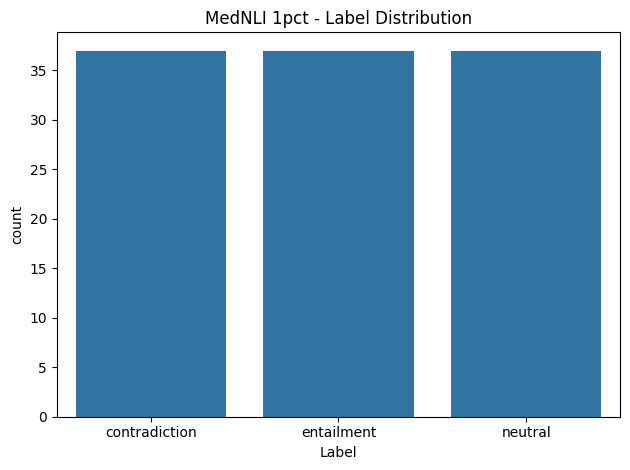

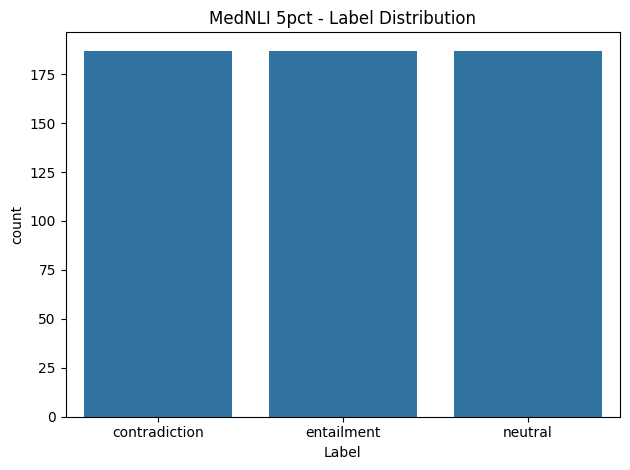

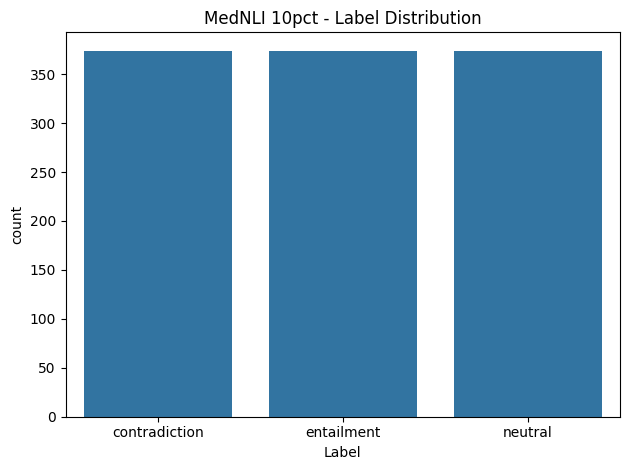

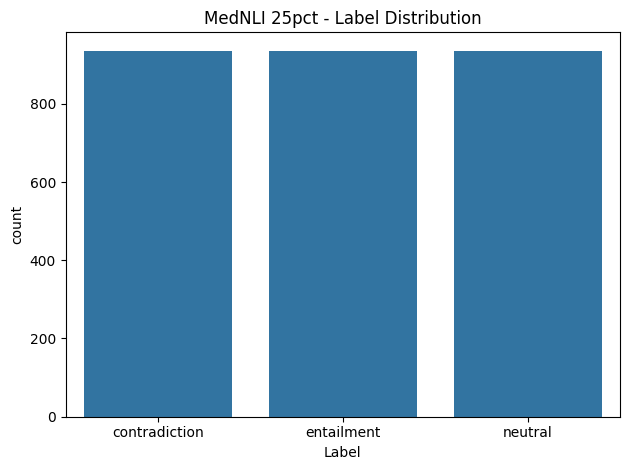

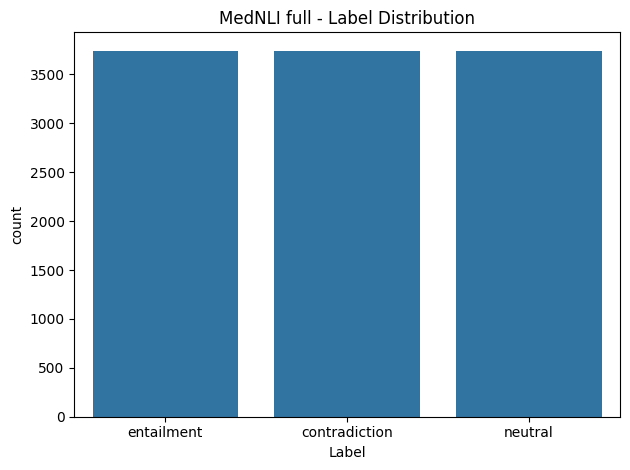

<ipython-input-8-71ca5e9a71a4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Sentence Length"] = filtered_df["sentence"].apply(lambda x: len(str(x).split()))
<ipython-input-8-71ca5e9a71a4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Label Count"] = filtered_df["labels"].apply(lambda x: len(str(x).split(",")))


⚠️  Warning: CLIP 1pct-train (label count) is imbalanced. Most frequent class = 1 (94.3%)


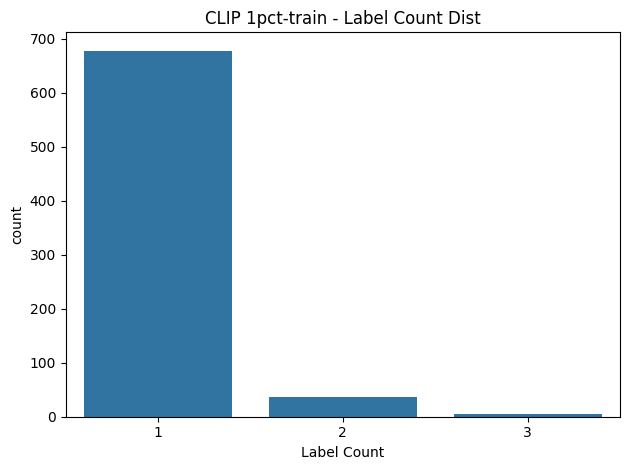

⚠️  Warning: CLIP 1pct-val (label count) is imbalanced. Most frequent class = 1 (96.8%)


<ipython-input-8-71ca5e9a71a4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Sentence Length"] = filtered_df["sentence"].apply(lambda x: len(str(x).split()))
<ipython-input-8-71ca5e9a71a4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Label Count"] = filtered_df["labels"].apply(lambda x: len(str(x).split(",")))


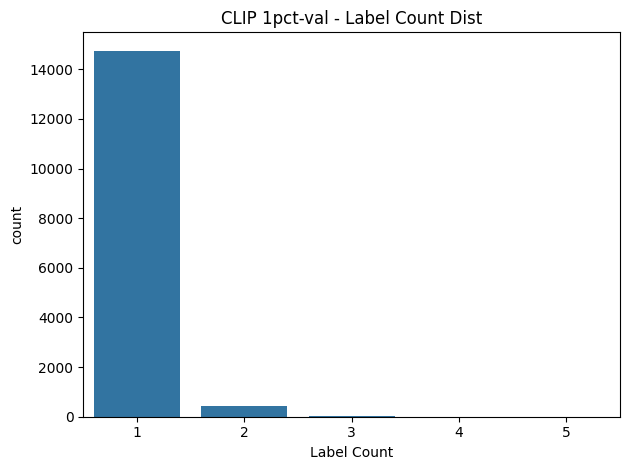

⚠️  Warning: CLIP 5pct-train (label count) is imbalanced. Most frequent class = 1 (95.7%)


<ipython-input-8-71ca5e9a71a4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Sentence Length"] = filtered_df["sentence"].apply(lambda x: len(str(x).split()))
<ipython-input-8-71ca5e9a71a4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Label Count"] = filtered_df["labels"].apply(lambda x: len(str(x).split(",")))


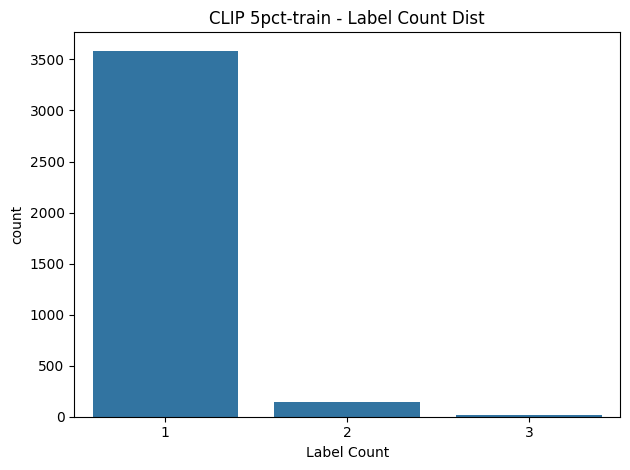

⚠️  Warning: CLIP 5pct-val (label count) is imbalanced. Most frequent class = 1 (96.8%)


<ipython-input-8-71ca5e9a71a4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Sentence Length"] = filtered_df["sentence"].apply(lambda x: len(str(x).split()))
<ipython-input-8-71ca5e9a71a4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Label Count"] = filtered_df["labels"].apply(lambda x: len(str(x).split(",")))


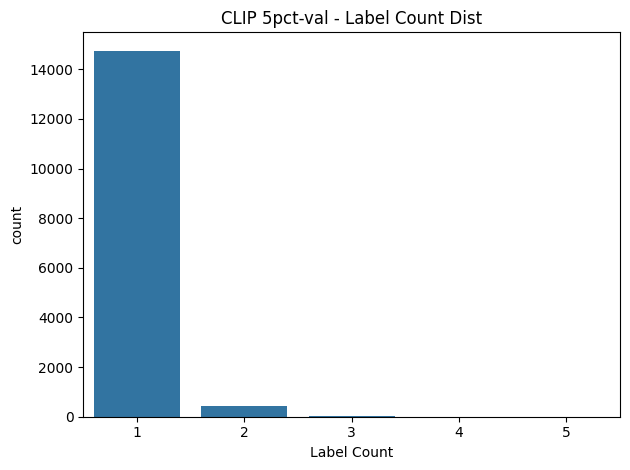

⚠️  Warning: CLIP 10pct-train (label count) is imbalanced. Most frequent class = 1 (96.2%)


<ipython-input-8-71ca5e9a71a4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Sentence Length"] = filtered_df["sentence"].apply(lambda x: len(str(x).split()))
<ipython-input-8-71ca5e9a71a4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Label Count"] = filtered_df["labels"].apply(lambda x: len(str(x).split(",")))


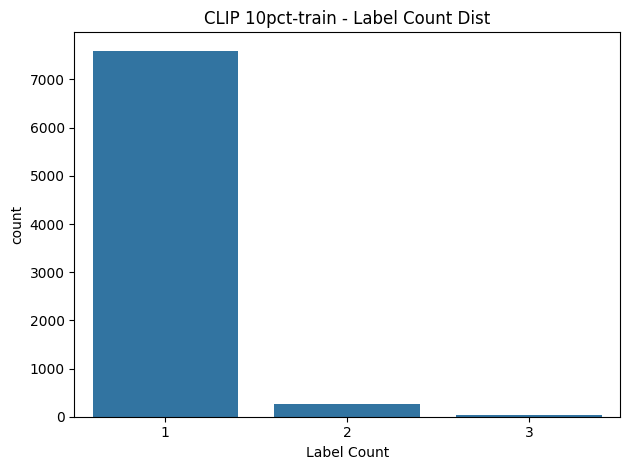

⚠️  Warning: CLIP 10pct-val (label count) is imbalanced. Most frequent class = 1 (96.8%)


<ipython-input-8-71ca5e9a71a4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Sentence Length"] = filtered_df["sentence"].apply(lambda x: len(str(x).split()))
<ipython-input-8-71ca5e9a71a4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Label Count"] = filtered_df["labels"].apply(lambda x: len(str(x).split(",")))


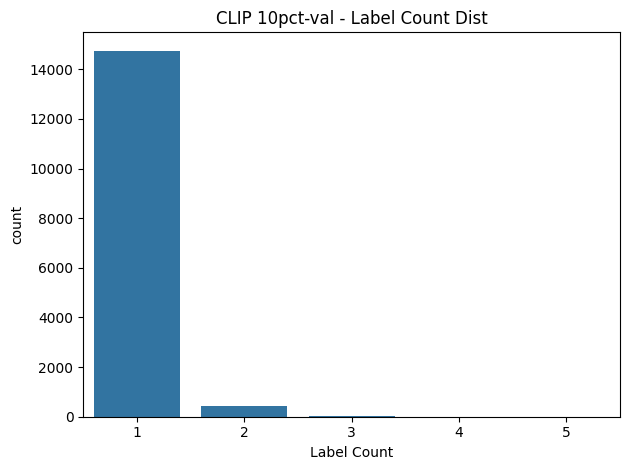

⚠️  Warning: CLIP 25pct-train (label count) is imbalanced. Most frequent class = 1 (96.6%)


<ipython-input-8-71ca5e9a71a4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Sentence Length"] = filtered_df["sentence"].apply(lambda x: len(str(x).split()))
<ipython-input-8-71ca5e9a71a4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Label Count"] = filtered_df["labels"].apply(lambda x: len(str(x).split(",")))


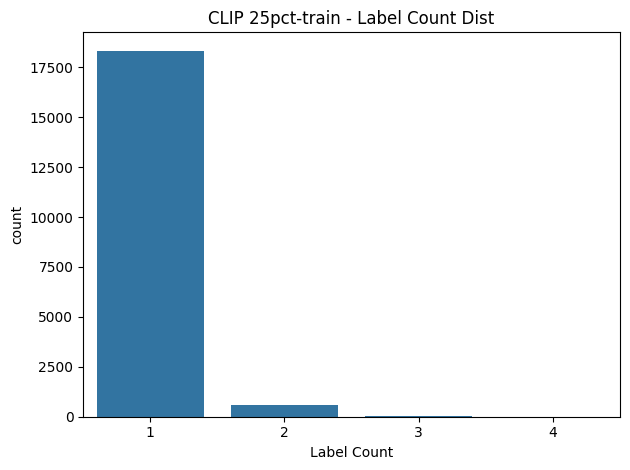

⚠️  Warning: CLIP 25pct-val (label count) is imbalanced. Most frequent class = 1 (96.8%)


<ipython-input-8-71ca5e9a71a4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Sentence Length"] = filtered_df["sentence"].apply(lambda x: len(str(x).split()))
<ipython-input-8-71ca5e9a71a4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Label Count"] = filtered_df["labels"].apply(lambda x: len(str(x).split(",")))


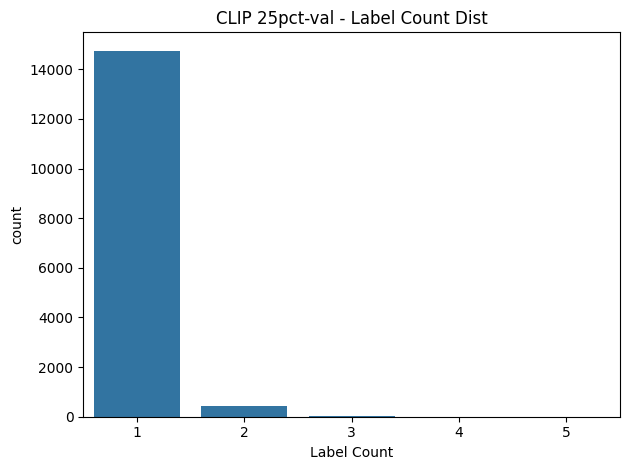

<ipython-input-8-71ca5e9a71a4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Sentence Length"] = filtered_df["sentence"].apply(lambda x: len(str(x).split()))
<ipython-input-8-71ca5e9a71a4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Label Count"] = filtered_df["labels"].apply(lambda x: len(str(x).split(",")))


⚠️  Warning: CLIP full-train (label count) is imbalanced. Most frequent class = 1 (96.8%)


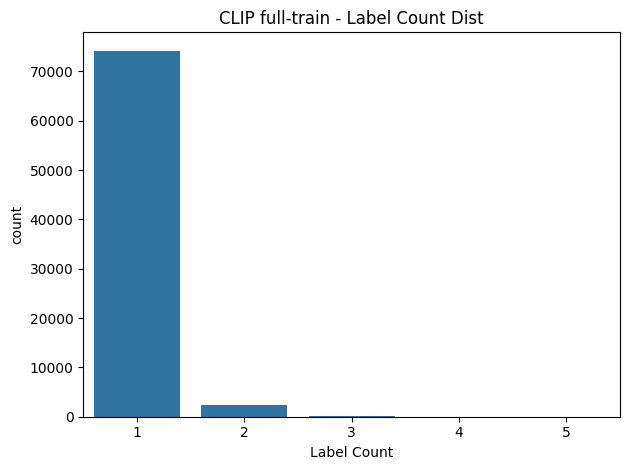

⚠️  Warning: CLIP full-val (label count) is imbalanced. Most frequent class = 1 (96.8%)


<ipython-input-8-71ca5e9a71a4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Sentence Length"] = filtered_df["sentence"].apply(lambda x: len(str(x).split()))
<ipython-input-8-71ca5e9a71a4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Label Count"] = filtered_df["labels"].apply(lambda x: len(str(x).split(",")))


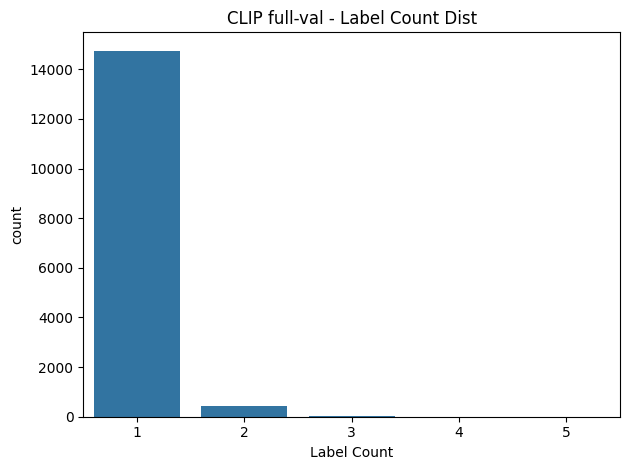

📋 MedNLI Summary Stats
--- 1pct ---
        Premise Length  Hypothesis Length
count      111.000000         111.000000
mean        18.621622           5.540541
std          9.160244           1.971542
min          3.000000           2.000000
25%         12.000000           4.000000
50%         18.000000           5.000000
75%         25.000000           7.000000
max         46.000000          13.000000 

--- 5pct ---
        Premise Length  Hypothesis Length
count      561.000000         561.000000
mean        16.368984           5.509804
std         10.280236           1.923629
min          3.000000           2.000000
25%          9.000000           4.000000
50%         14.000000           5.000000
75%         21.000000           6.000000
max         57.000000          16.000000 

--- 10pct ---
        Premise Length  Hypothesis Length
count     1122.000000        1122.000000
mean        15.927807           5.467023
std         11.661948           1.840975
min          3.000000       

In [ ]:
# 📊 Phase 2.7: Dataset Visualization and Validation (With Assertions and Slimmed Visuals)

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer

subsets = ["1pct", "5pct", "10pct", "25pct", "full"]
mednli_summary, radqa_summary, clip_summary = {}, {}, {}

# Warn if class imbalance is extreme
def warn_imbalance(series, label):
    counts = series.value_counts(normalize=True)
    if counts.max() > 0.9:
        print(f"⚠️  Warning: {label} is imbalanced. Most frequent class = {counts.idxmax()} ({counts.max():.1%})")

# Simple count plot for labels
def quick_bar(data, title, xlabel):
    sns.countplot(x=data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

# --- MedNLI ---
for subset in subsets:
    file_path = os.path.join(DATA_DIR, "mednli", subset, "train.jsonl")
    if not os.path.exists(file_path): continue
    with open(file_path, "r") as f:
        data = [json.loads(line) for line in f if line.strip()]
    df = pd.DataFrame({
        "Premise Length": [len(x["sentence1"].split()) for x in data],
        "Hypothesis Length": [len(x["sentence2"].split()) for x in data],
        "Label": [x.get("label") or x.get("gold_label", "unknown") for x in data]
    })
    assert len(df) > 0, f"❌ Empty dataset for MedNLI {subset}"
    warn_imbalance(df["Label"], f"MedNLI {subset}")
    quick_bar(df["Label"], f"MedNLI {subset} - Label Distribution", "Label")
    mednli_summary[subset] = df.describe()

# --- RadQA ---
for subset in subsets:
    file_path = os.path.join(DATA_DIR, "radqa", subset, "train.json")
    if not os.path.exists(file_path): continue
    with open(file_path, "r") as f:
        parsed = json.load(f)
    entries = []
    for doc in parsed["data"]:
        for para in doc["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answer = qa["answers"][0]["text"] if qa["answers"] else ""
                entries.append((question, context, answer))
    df = pd.DataFrame({
        "Question Length": [len(q.split()) for q, _, _ in entries],
        "Context Length": [len(c.split()) for _, c, _ in entries],
        "Answer Length": [len(a.split()) for _, _, a in entries]
    })
    assert len(df) > 0, f"❌ Empty dataset for RadQA {subset}"
    radqa_summary[subset] = df.describe()

# --- CLIP ---
for subset in subsets:
    sent_path = os.path.join(DATA_DIR, "clip", subset, "sentence_level.csv")
    for split in ["train", "val"]:
        ids_path = os.path.join(DATA_DIR, "clip", subset, f"{split}_ids.csv")
        if not (os.path.exists(sent_path) and os.path.exists(ids_path)):
            continue

        # Load sentence and ID data
        sent_df = pd.read_csv(sent_path)
        ids = pd.read_csv(ids_path, header=None).squeeze("columns").astype(str).tolist()

        # Filter using doc_id match instead of uid
        filtered_df = sent_df[sent_df["doc_id"].astype(str).isin(ids)]

        # Basic validation
        assert len(filtered_df) > 0, f"❌ Empty dataset for CLIP {subset}-{split}"

        # Label & sentence processing
        filtered_df["Sentence Length"] = filtered_df["sentence"].apply(lambda x: len(str(x).split()))
        filtered_df["Label Count"] = filtered_df["labels"].apply(lambda x: len(str(x).split(",")))

        # Imbalance warning and visualization
        warn_imbalance(filtered_df["Label Count"], f"CLIP {subset}-{split} (label count)")
        quick_bar(filtered_df["Label Count"], f"CLIP {subset}-{split} - Label Count Dist", "Label Count")

        # Store summary
        clip_summary[f"{subset}-{split}"] = filtered_df[["Sentence Length", "Label Count"]].describe()

# Print summaries
print("📋 MedNLI Summary Stats")
for k, v in mednli_summary.items():
    print(f"--- {k} ---\n", v, "\n")

print("📋 RadQA Summary Stats")
for k, v in radqa_summary.items():
    print(f"--- {k} ---\n", v, "\n")

print("📋 CLIP Summary Stats")
for k, v in clip_summary.items():
    print(f"--- {k} ---\n", v, "\n")

## ✅ Phase 2.8: Dataset Processing Summary and Readiness Check

This section summarizes the outcomes from Phase 2.7 and evaluates readiness for model fine-tuning across all datasets and subset variants.


In [ ]:
# Phase 2.8 - Summary and Next Steps

from pprint import pprint

# Summary of processed subsets
print("✅ Processed MedNLI Subsets:", list(mednli_summary.keys()))
print("✅ Processed RadQA Subsets:", list(radqa_summary.keys()))
print("✅ Processed CLIP Subsets:", list(clip_summary.keys()))

# Print sample stats from each
print("\n📊 Sample Summary (MedNLI - full)")
if "full" in mednli_summary:
    pprint(mednli_summary["full"])
else:
    print("❌ MedNLI full subset not available")

print("\n📊 Sample Summary (RadQA - full)")
if "full" in radqa_summary:
    pprint(radqa_summary["full"])
else:
    print("❌ RadQA full subset not available")

print("\n📊 Sample Summary (CLIP - full-train)")
if "full-train" in clip_summary:
    pprint(clip_summary["full-train"])
else:
    print("❌ CLIP full-train subset not available")

# Readiness validation
readiness = (
    len(mednli_summary) > 0 and
    len(radqa_summary) > 0 and
    any(k.startswith("full") for k in clip_summary)
)

if readiness:
    print("\n✅ All dataset subsets are preprocessed and ready for model fine-tuning.")
else:
    print("\n❌ One or more datasets are missing. Investigate and reprocess as needed.")


✅ Processed MedNLI Subsets: ['1pct', '5pct', '10pct', '25pct', 'full']
✅ Processed RadQA Subsets: ['1pct', '5pct', '10pct', '25pct', 'full']
✅ Processed CLIP Subsets: ['1pct-train', '1pct-val', '5pct-train', '5pct-val', '10pct-train', '10pct-val', '25pct-train', '25pct-val', 'full-train', 'full-val']

📊 Sample Summary (MedNLI - full)
       Premise Length  Hypothesis Length
count    11232.000000       11232.000000
mean        15.911592           5.483974
std         11.299373           1.792333
min          3.000000           1.000000
25%          8.000000           4.000000
50%         13.000000           5.000000
75%         20.000000           6.000000
max        140.000000          17.000000

📊 Sample Summary (RadQA - full)
       Question Length  Context Length  Answer Length
count      4878.000000     4878.000000    4878.000000
mean          7.635096       77.304428      11.954695
std           2.227683       93.146694      26.748293
min           2.000000        1.000000       0

## Visualization of Dataset, one per dataset

<ipython-input-13-976c11230716>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="pastel")


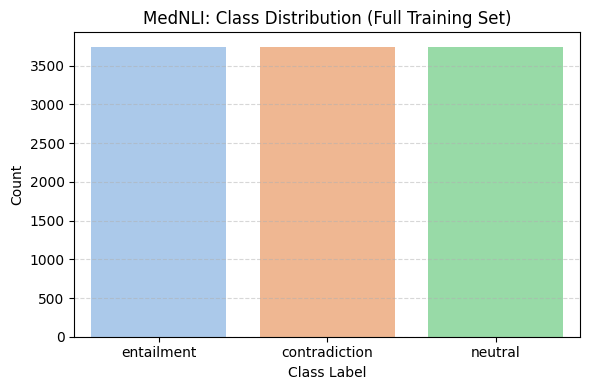

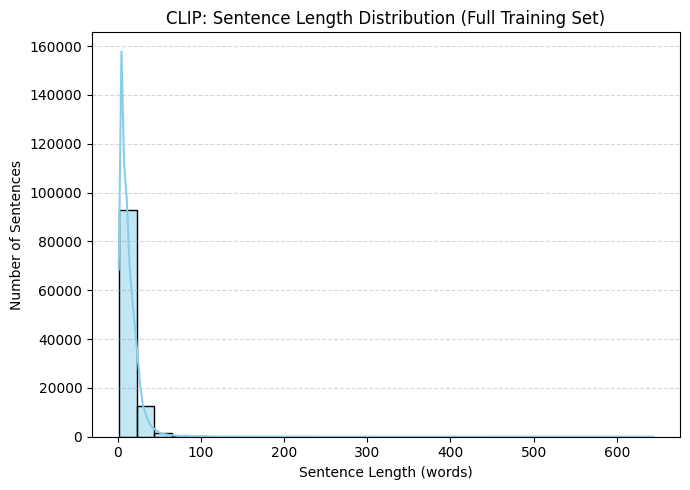

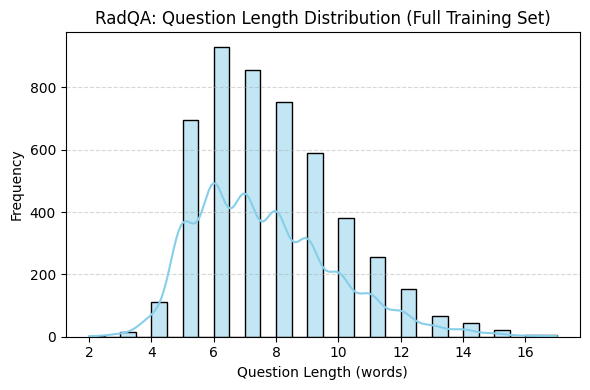

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import numpy as np

#───────────────────────────────────────────────────────────────────────────────
# 📈 MedNLI Visualization: Class Distribution
#───────────────────────────────────────────────────────────────────────────────

def plot_mednli_class_distribution(mednli_train_path):
    labels = []
    with open(mednli_train_path, "r") as f:
        for line in f:
            ex = json.loads(line)
            labels.append(ex["gold_label"])

    label_counts = pd.Series(labels).value_counts()

    plt.figure(figsize=(6,4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="pastel")
    plt.title("MedNLI: Class Distribution (Full Training Set)")
    plt.ylabel("Count")
    plt.xlabel("Class Label")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/DL4H-Project/results/mednli_class_distribution.png", dpi=300)
    plt.show()



# Example usage:
# plot_mednli_class_distribution("/content/drive/MyDrive/DL4H-Project/data/mednli/full/train.jsonl")

#───────────────────────────────────────────────────────────────────────────────
# 📈 CLIP Visualization: Label Frequency
#───────────────────────────────────────────────────────────────────────────────

def plot_clip_label_distribution(clip_sentence_level_csv):
    df_clip = pd.read_csv(clip_sentence_level_csv)

    expected_labels = [
        "appointment-related",
        "medication-related",
        "lab-related",
        "patient-instructions",
        "procedure-related",
        "imaging-related",
        "other"
    ]

    if "labels" not in df_clip.columns:
        print("⚠️ 'labels' column not found!")
        return

    # Build label mapping
    valid_labels_set = set(expected_labels) - {"other"}

    # Expand labels
    all_mapped_labels = []
    for labels in df_clip["labels"].dropna():
        split_labels = [lbl.strip() for lbl in labels.split(",") if lbl.strip()]
        for lbl in split_labels:
            if lbl in valid_labels_set:
                all_mapped_labels.append(lbl)
            else:
                all_mapped_labels.append("other")

    if not all_mapped_labels:
        print("⚠️ No valid labels found!")
        return

    # Count
    label_counts = pd.Series(all_mapped_labels).value_counts().reindex(expected_labels, fill_value=0)

    # Plot
    plt.figure(figsize=(8,5))
    sns.barplot(x=label_counts.values, y=label_counts.index, palette="pastel")
    plt.title("CLIP: Mapped Label Frequencies (Sentence Level with Full Training Set)")
    plt.xlabel("Number of Sentences")
    plt.ylabel("Label Category")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/DL4H-Project/results/clip_label_distribution.png", dpi=300)
    plt.show()

# Example usage:
# plot_clip_label_distribution("/content/drive/MyDrive/DL4H-Project/data/clip/sentence_level.csv")

#───────────────────────────────────────────────────────────────────────────────
# 📈 RadQA Visualization: Question Length Distribution
#───────────────────────────────────────────────────────────────────────────────

def plot_radqa_question_lengths(radqa_train_path):
    questions = []
    with open(radqa_train_path, "r") as f:
        data = json.load(f)
        for ex in data["data"]:
            for para in ex["paragraphs"]:
              for qa in para["qas"]:
                  questions.append(qa["question"])

    question_lengths = [len(q.split()) for q in questions]

    plt.figure(figsize=(6,4))
    sns.histplot(question_lengths, bins=30, kde=True, color="skyblue")
    plt.title("RadQA: Question Length Distribution (Full Training Set)")
    plt.xlabel("Question Length (words)")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/DL4H-Project/results/radqa_question_lengths.png", dpi=300)
    plt.show()

#───────────────────────────────────────────────────────────────────────────────
# 📈 CLIP Visualization: Sentence Length Frequency
#───────────────────────────────────────────────────────────────────────────────
def plot_clip_sentence_lengths(clip_sentence_level_csv):
    df_clip = pd.read_csv(clip_sentence_level_csv)

    if "sentence" not in df_clip.columns:
        print("⚠️ 'sentence' column not found!")
        return

    # Calculate sentence lengths (number of words)
    sentence_lengths = df_clip["sentence"].dropna().apply(lambda x: len(str(x).split()))

    plt.figure(figsize=(7,5))
    sns.histplot(sentence_lengths, bins=30, kde=True, color="skyblue")
    plt.title("CLIP: Sentence Length Distribution (Full Training Set)")
    plt.xlabel("Sentence Length (words)")
    plt.ylabel("Number of Sentences")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/DL4H-Project/results/clip_sentence_lengths.png", dpi=300)
    plt.show()

# Example usage:
plot_mednli_class_distribution("/content/drive/MyDrive/DL4H-Project/data/mednli/full/train.jsonl")
plot_clip_sentence_lengths("/content/drive/MyDrive/DL4H-Project/data/clip/sentence_level.csv")
# plot_clip_label_distribution("/content/drive/MyDrive/DL4H-Project/data/clip/sentence_level.csv")
plot_radqa_question_lengths("/content/drive/MyDrive/DL4H-Project/data/radqa/full/train.json")

